# **1. Pacotes**

In [ ]:
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)

In [ ]:
#from psutil import virtual_memory
#ram_gb = virtual_memory().total / 1e9
#print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

#if ram_gb < 20:
#  print('Not using a high-RAM runtime')
#else:
#  print('You are using a high-RAM runtime!')

Exemplo de fórmula que dá para colocar: $\mathrm{e}^{i \pi} - 1 = 0$

In [ ]:
install.packages(c('abc','splines2','keras'),dependencies = T)#ggrepel,glmnet

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘RcppTOML’, ‘here’, ‘config’, ‘tfautograph’, ‘abc.data’, ‘quantreg’, ‘locfit’, ‘Rcpp’, ‘RcppArmadillo’, ‘tinytest’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’, ‘tfdatasets’, ‘png’, ‘jpeg’




In [ ]:
require("MASS")
require("tidyverse")
require("abc")
library(ggplot2)
#library(dplyr)
#library(tidyr)
library(splines2)
library(keras)
library(tensorflow)
options(repr.plot.width=10, repr.plot.height=8)

Loading required package: MASS

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()

Loading required package: abc

Loading required package: abc.data

Loading required package: nnet

Loading required package: quantreg

Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Loading required package: locfit

locfit 1.5-9.7 	 2023-01-02


Attaching package: ‘locfit’


The following object is masked from ‘pa

# **4. Exemplo Twisted Gaussian**

Decomposição da posteriori
p(theta1, theta2| y) = p(theta1|y) * p(theta2|theta1, y)  Fatoração 1
                     = p(theta2|y) * p(theta1|theta2, y)  Fatoração 2
Gibbs: aproximar p(theta1|theta2, y) e p(theta2|theta1, y) e iterar

Algoritmo
1) regressão quantilica de theta1 em função de y
2) regressão quantilica de theta2 em função theta1 e y
3) prever m amostras de p(theta1|y=1)
4) para cada amostra (de 1 a m), gerar theta2_i | theta1_i, y=1

Objetivos:
1) Usar o algoritmo via regressão quantilica para gerar amostras da posteriori
    Verificar se o algoritmo funciona (por exemplo, se gera pontos na mesma região da posteriori exata)
2) Comparar a performance com as duas fatorações possíveis (Fatoração 1 e 2).
3) Comparar com uma aproximação que assume que cada termo da fatoração é normal.
4) Comparar com o Gibbs exato (se as distribuições condicionais completas foram acessíveis) ou da Débora.

## **4.1 Geração dos dados**

In [ ]:
# Gerando dados sintéticos ----
n <- 1000000#1000000
theta1 <- rnorm(n)
theta2 <- rnorm(n)
erro <- rnorm(n, sd=.1)
y <- theta1 + theta2^2 + erro
params <- tibble(theta1 = theta1,
                theta2 = theta2)

mod <- abc(1, params, y, tol=0.005, method="loclinear")
regM1=data.frame(y=y,theta1=theta1,theta2=theta2)
y_obs=1 # Valor observado

Warning message:
“All parameters are "none" transformed.”
Warning message in abc(1, params, y, tol = 0.005, method = "loclinear"):
“No summary statistics names are given, using S1, S2, ...”


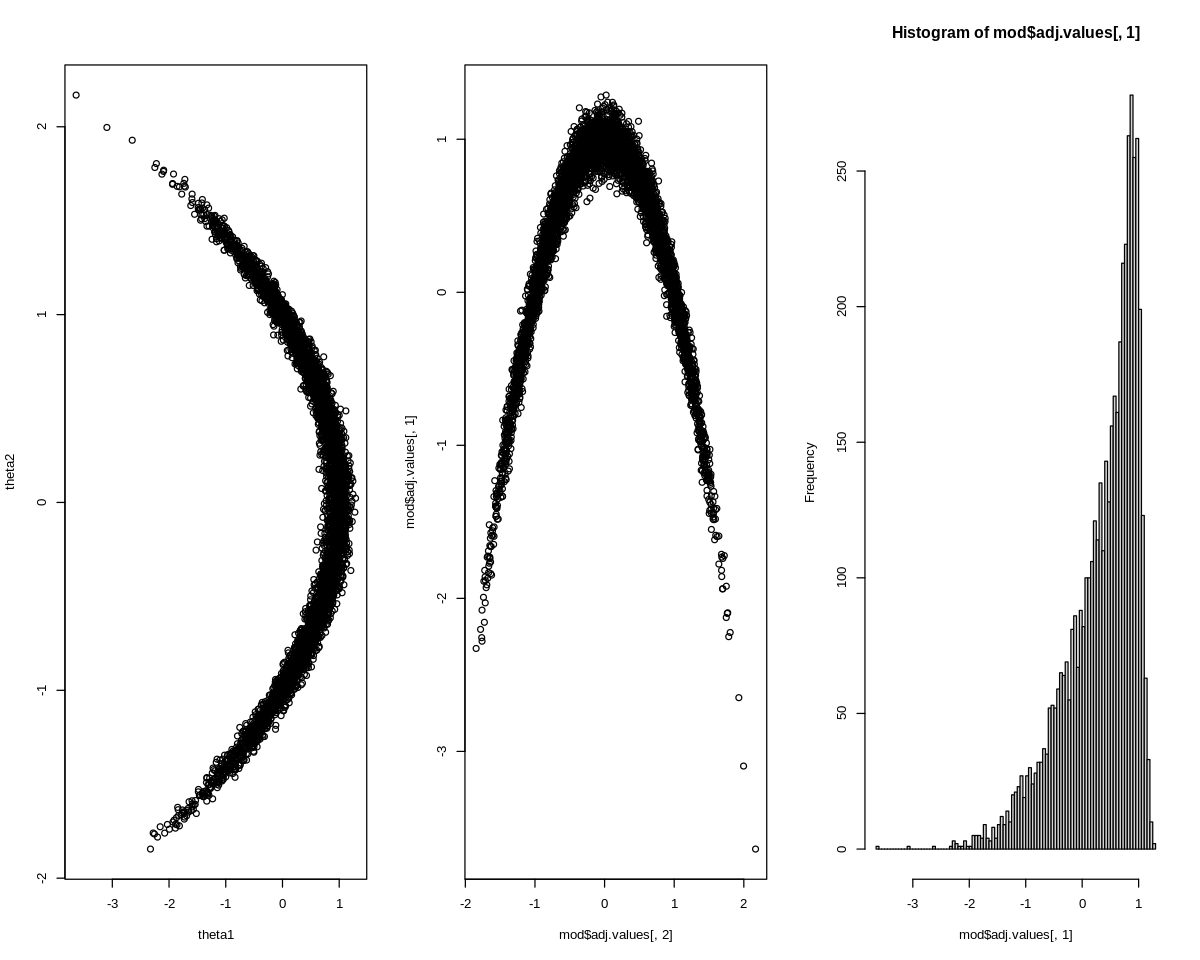

In [ ]:
par(mfrow = c(1,3))
plot(mod$adj.values)
plot(mod$adj.values[, 2], mod$adj.values[, 1])
hist(mod$adj.values[, 1], breaks=100)

## **4.2 Algoritmos**

### **4.2.1 Separação dos dados**

Os dados já foram gerados, estou importando para que não precisa gerar de novo

In [ ]:
# data split ===================================================================

n=nrow(regM1)
m.gibbs<-5000
#Separacao base de treino e validacao
indextrain <- sample(1:n,round(0.8*n),replace=FALSE)
base_train <- regM1[ indextrain,]
base_test <- regM1[-indextrain,]
base_train <- regM1[ indextrain,]
base_test <- regM1[-indextrain,]

### **4.2.2 Funções**

In [ ]:
# ajuste regressao quantilica com redes neurais ================================
fitRq = function(x, y, xtest, ytest,tau) {
  
  x = as.matrix(x)
  y = as.matrix(y)
  xtest=as.matrix(xtest)
  ytest=as.matrix(ytest)
  
  #funcao de perda
  tilted_loss = function(q, y, f) {
    e = y - f
    return(k_mean(k_maximum(q * e, (q - 1) * e)))
  }
  
  model = keras_model_sequential() %>%
    
    layer_dense(units = 512, activation = 'relu', input_shape = ncol(x)) %>%
    layer_dropout(0.4) %>%
    layer_dense(units = 256, activation = 'relu',kernel_regularizer = regularizer_l2(l = 0.01))%>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    layer_dense(units = 16, activation = 'relu') %>%
    layer_dense(units = length(tau))
  
  
  model %>% compile(optimizer='adam',#optimizer_adam(learning_rate = 0.2)
                    loss = function(y, yP) return(tilted_loss(tau, y, yP)),
                    metrics = "mse")#metrics = list("accuracy")
  
  lista<-model %>% fit(x, y,
                batch_size = 64,
                epochs = 100,
                verbose = 1,
                #callbacks = list(callback_early_stopping(monitor = "val_loss", 
                #patience = 20,min_delta=.01, 
                #mode='min',
                #restore_best_weights = TRUE)),
                validation_data = list(xtest, ytest))
  print(plot(lista))
  print(model %>% evaluate(xtest, ytest))
  return(model)
}

predictRq = function(fitModel, x, tau) {
  
  x = as.matrix(x)
  
  yHat = fitModel %>% predict(x)
  colnames(yHat) = paste0('quantile= ', tau)
  
  return(yHat)
}

### **4.2.3 Fatorações**

#### **4.2.3.1 Regressão quantílica + fatoração p(theta_1|y) * p(theta_2|theta_1,y)**

In [ ]:
#Dados para estimar Theta1

Xtrain <- base_train[,c(1)]#tirar o 4
Xtest <- base_test[,c(1)]#tirar o 4
Ytrain <- base_train[,2]
Ytest <- base_test[,2]

#.....................................................
#Dados para estimar Theta2

Xtrain2 <- base_train[,c(1:2)]
Xtest2 <- base_test[,c(1:2)]
Ytrain2 <- base_train[,3]
Ytest2 <- base_test[,3]

#===============================================================================

In [ ]:
tau

[1] 0.002472623 0.002731961 0.003018416 0.003334807 0.003684240 0.004070138
  [7] 0.004496273 0.004966802 0.005486299 0.006059801 0.006692851 0.007391541
 [13] 0.008162571 0.009013299 0.009951802 0.010986943 0.012128435 0.013386918
 [19] 0.014774032 0.016302499 0.017986210 0.019840306 0.021881271 0.024127021
 [25] 0.026596994 0.029312231 0.032295465 0.035571189 0.039165723 0.043107255
 [31] 0.047425873 0.052153563 0.057324176 0.062973356 0.069138420 0.075858180
 [37] 0.083172696 0.091122961 0.099750489 0.109096821 0.119202922 0.130108474
 [43] 0.141851065 0.154465265 0.167981615 0.182425524 0.197816111 0.214165017
 [49] 0.231475217 0.249739894 0.268941421 0.289050497 0.310025519 0.331812228
 [55] 0.354343694 0.377540669 0.401312340 0.425557483 0.450166003 0.475020813
 [61] 0.500000000 0.524979187 0.549833997 0.574442517 0.598687660 0.622459331
 [67] 0.645656306 0.668187772 0.689974481 0.710949503 0.731058579 0.750260106
 [73] 0.768524783 0.785834983 0.802183889 0.817574476 0.832018385 0.845534735
 [79] 0.858148935 0.869891526 0.880797078 0.890903179 0.900249511 0.908877039
 [85] 0.916827304 0.924141820 0.930861580 0.937026644 0.942675824 0.947846437
 [91] 0.952574127 0.956892745 0.960834277 0.964428811 0.967704535 0.970687769
 [97] 0.973403006 0.975872979 0.978118729 0.980159694 0.982013790 0.983697501
[103] 0.985225968 0.986613082 0.987871565 0.989013057 0.990048198 0.990986701
[109] 0.991837429 0.992608459 0.993307149 0.993940199 0.994513701 0.995033198
[115] 0.995503727 0.995929862 0.996315760 0.996665193 0.996981584 0.997268039
[121] 0.997527377

     loss       mse 
0.0902087 1.9290705 


Time difference of 1.314969 hours

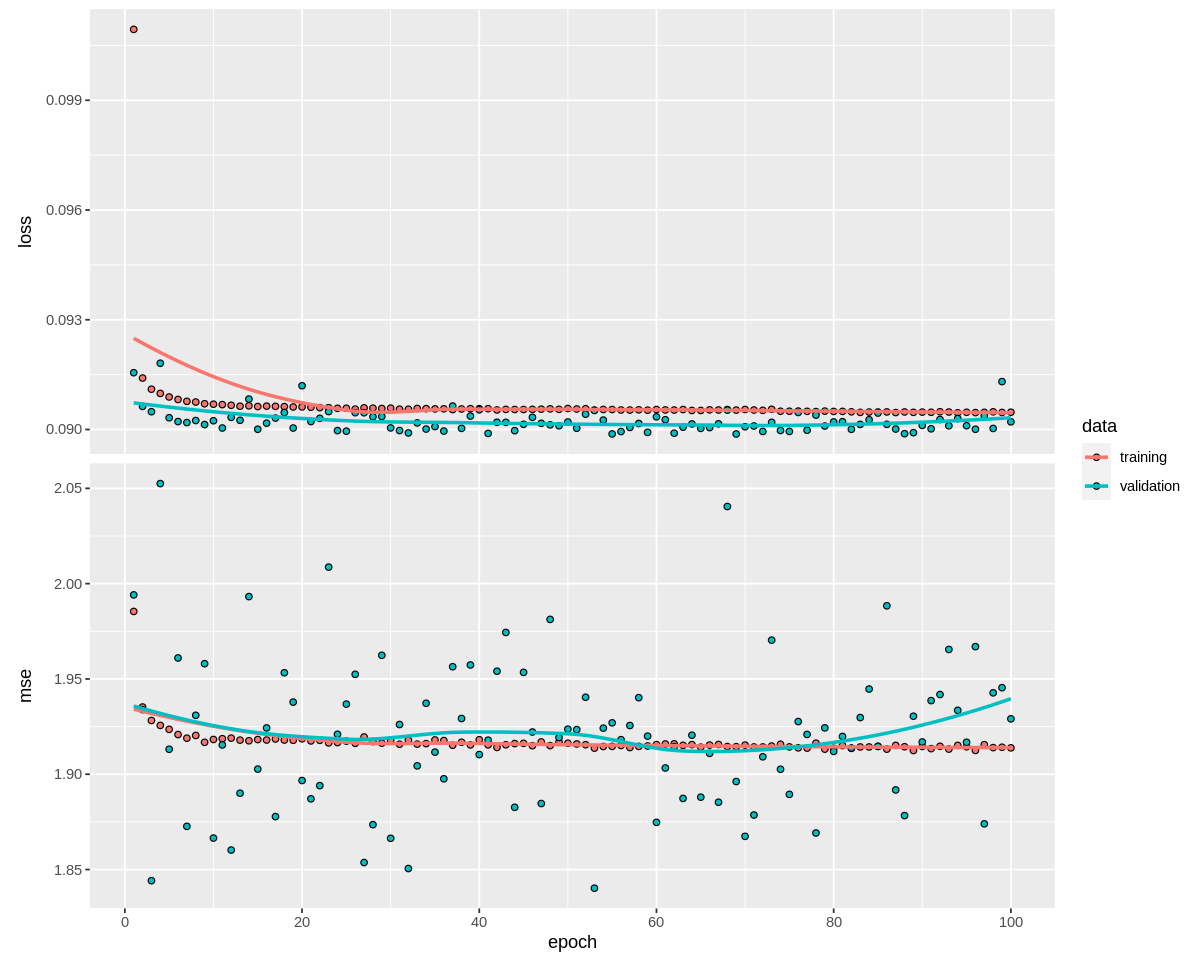

      loss        mse 
0.09868218 2.10953331 


Time difference of 1.302667 hours

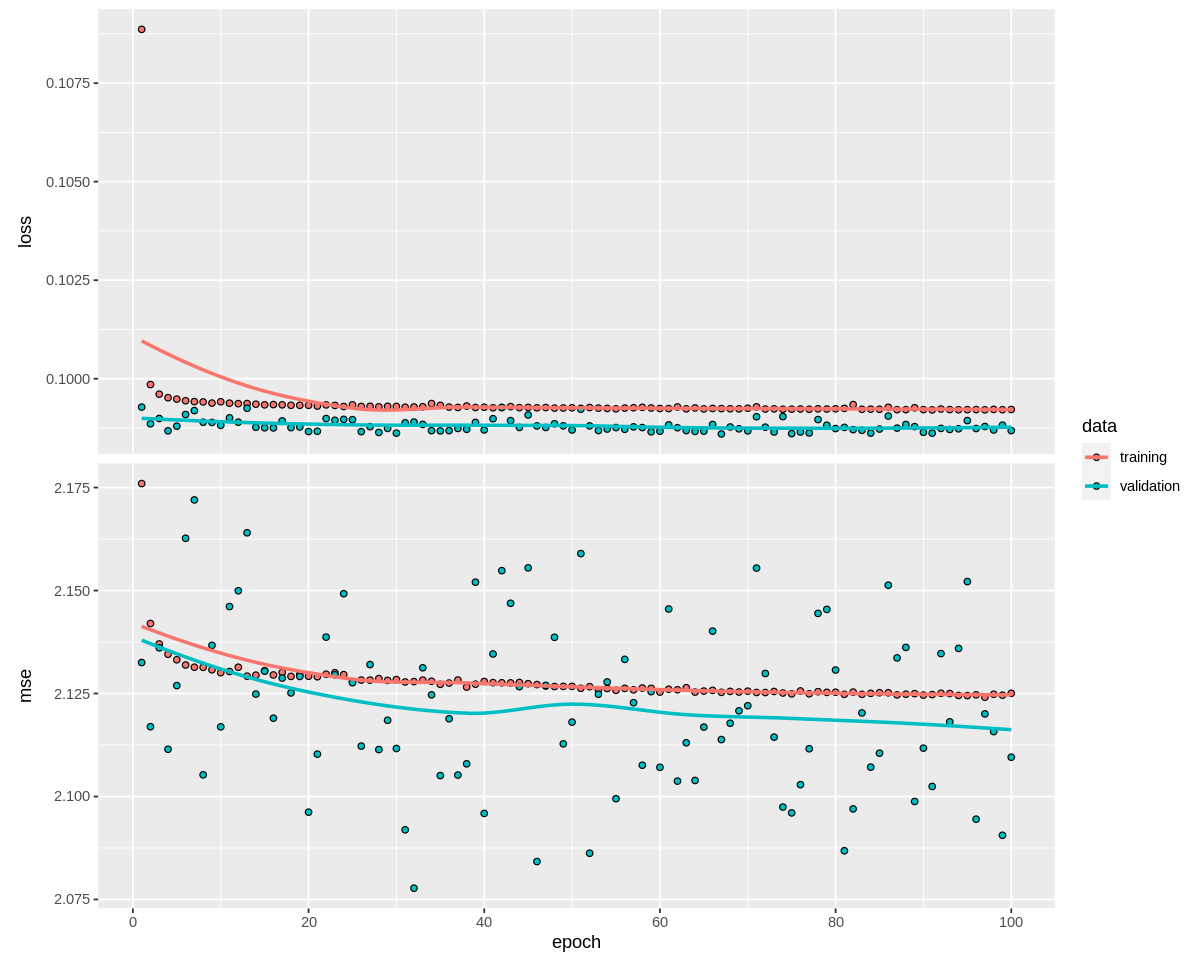

In [ ]:
# ajuste do modelo =============================================================
#Definição do Grid
gTau = seq(-6,6,0.1)#função logito
#Transformação Logito
tau = 1/(1+exp(-gTau))
#tau =c(.1,.1,.1,.1,.1)
inicio<-Sys.time()
fitTheta1 = fitRq(x = Xtrain,
                  y = Ytrain,
                  xtest=Xtest,
                  ytest=Ytest,
                  tau = tau)
fim<-Sys.time()
fim-inicio
inicio<-Sys.time()
fitTheta2 = fitRq(x = Xtrain2,
                  y = Ytrain2,
                  xtest=Xtest2,
                  ytest=Ytest2,
                  tau = tau)
#===============================================================================
fim<-Sys.time()
fim-inicio

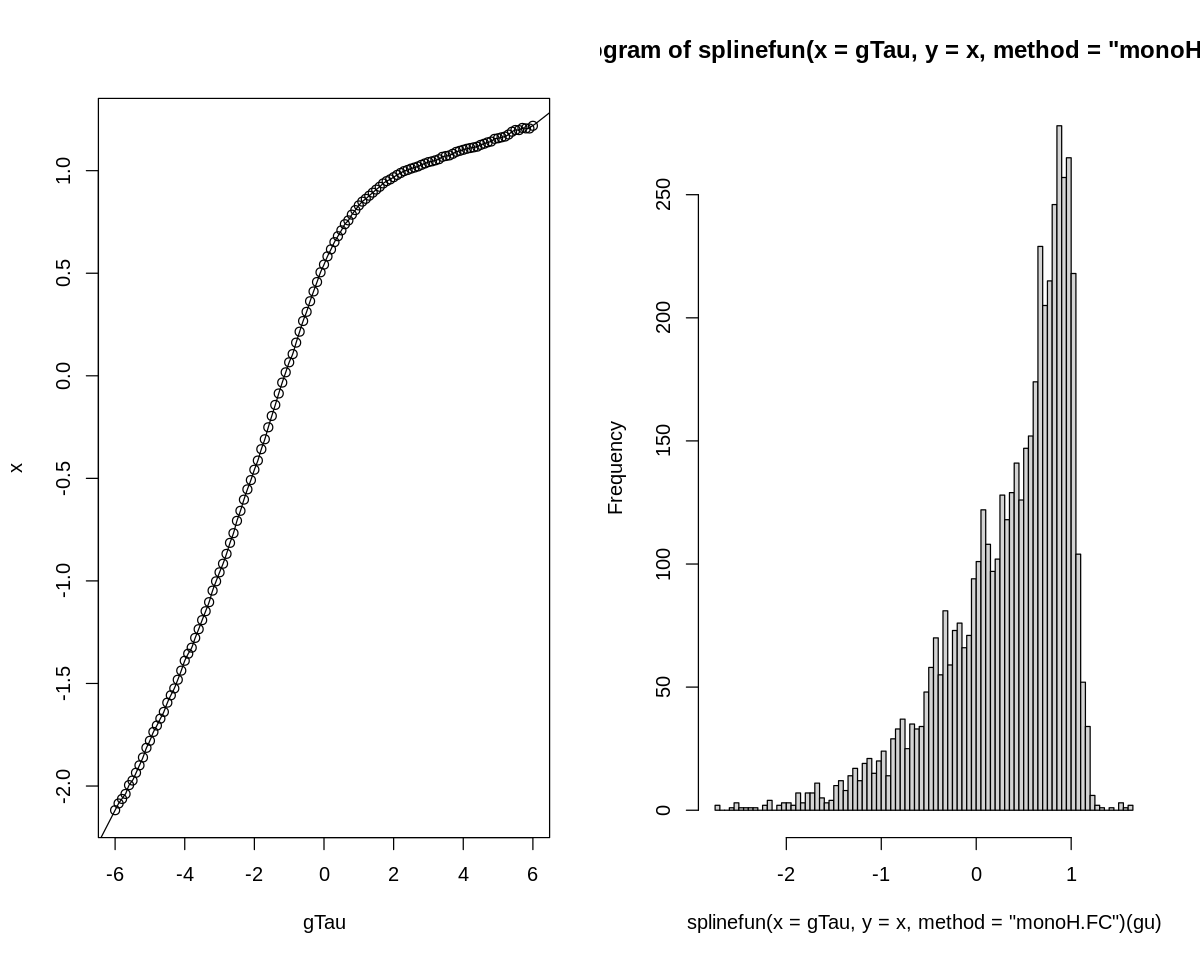

In [ ]:
thetaHat1 = predictRq(fitTheta1, matrix(c(1),ncol=1), tau)
x = as.numeric(thetaHat1)
u = runif(5000, .0, 1)
gu = log(u/(1-u))
gTau = seq(-6,6,0.1)
#TransformaÃ§Ã£o Logito
tau = 1/(1+exp(-gTau))

par(mfrow = c(1,2))
plot(gTau,x)
lines(sort(gu),splinefun(x = gTau, y = x,method ="monoH.FC")(sort(gu)))
#plot(x,tau)
hist(splinefun(x = gTau, y = x,method ="monoH.FC")(gu),breaks=100)

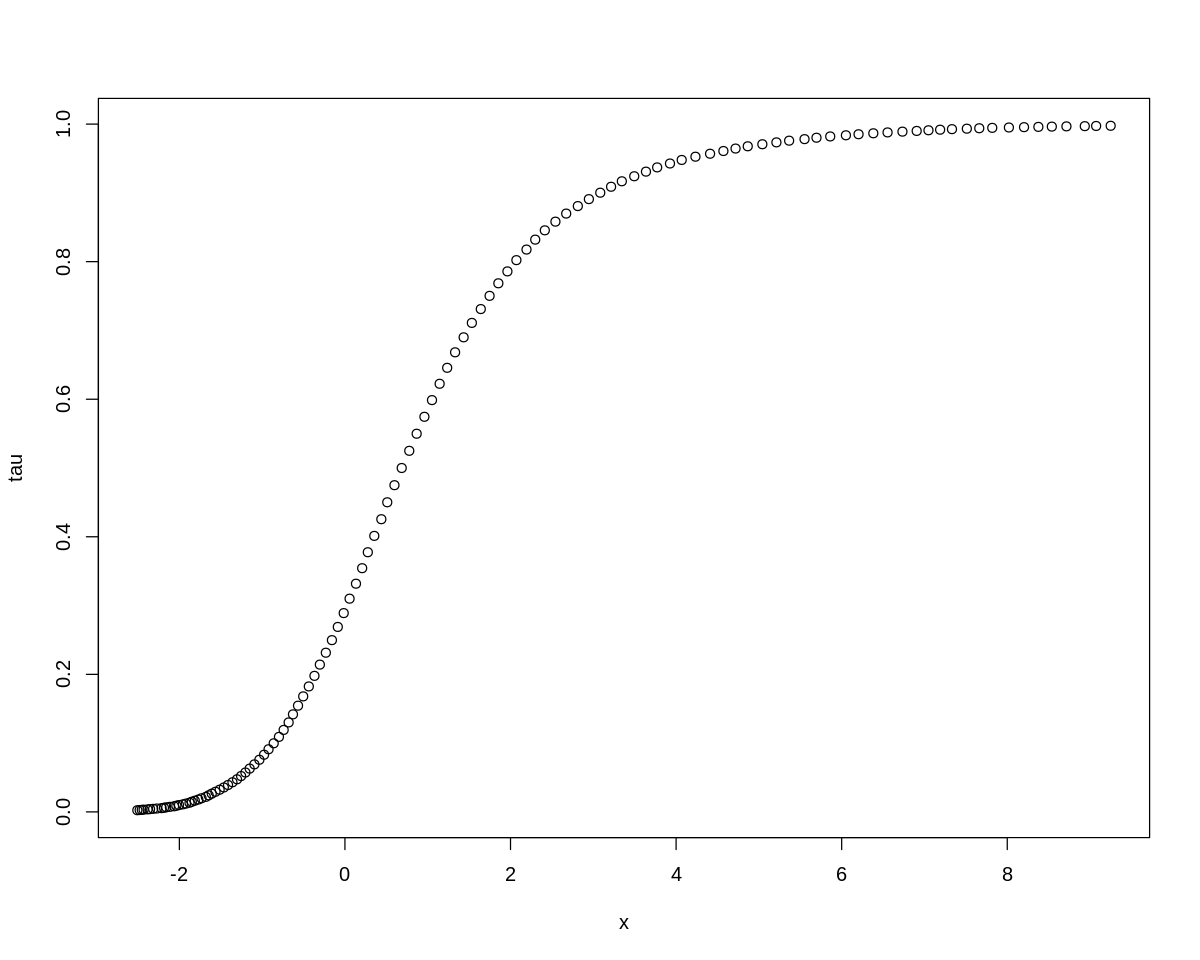

In [ ]:
plot(x,tau)

In [ ]:
# fatoração ========================================================================
fatoracoes<-5000
outG =  data.frame(matrix(NA, fatoracoes, nc = 3))
names(outG) = c('y', 'theta1', 'theta2')
#valor inicial s0:
outG[,1] = rep(1, fatoracoes)
#valor inicial para theta:
outG[1,2:3] = c(0, 0)

#obtencao dos valores preditos pelo modelo:

inicio<-Sys.time()
thetaHat1 = predictRq(fitTheta1, matrix(c(1),ncol=1), tau)
x = as.numeric(thetaHat1)
u = runif(fatoracoes, .0, 1)
gu = log(u/(1-u))
outG$theta1 = splinefun(x = gTau, y = x,method ="monoH.FC")(gu)

for(i in 1:fatoracoes){
  #theta2:
  #obtencao dos valores preditos pelo modelo:
  thetaHat2 = predictRq(fitTheta2, outG[i,c(1:2)], tau)
  x = as.numeric(thetaHat2)
  u = runif(1, .0, 1)
  gu = log(u/(1-u))
 outG$theta2[i] = splinefun(x = gTau, y =x,method ="monoH.FC")(gu)
}
fim<-Sys.time()
fim-inicio
fatoracao1<-outG[,c(2,3)]
colnames(fatoracao1)<-c('X1','X2')

Time difference of 5.119742 mins

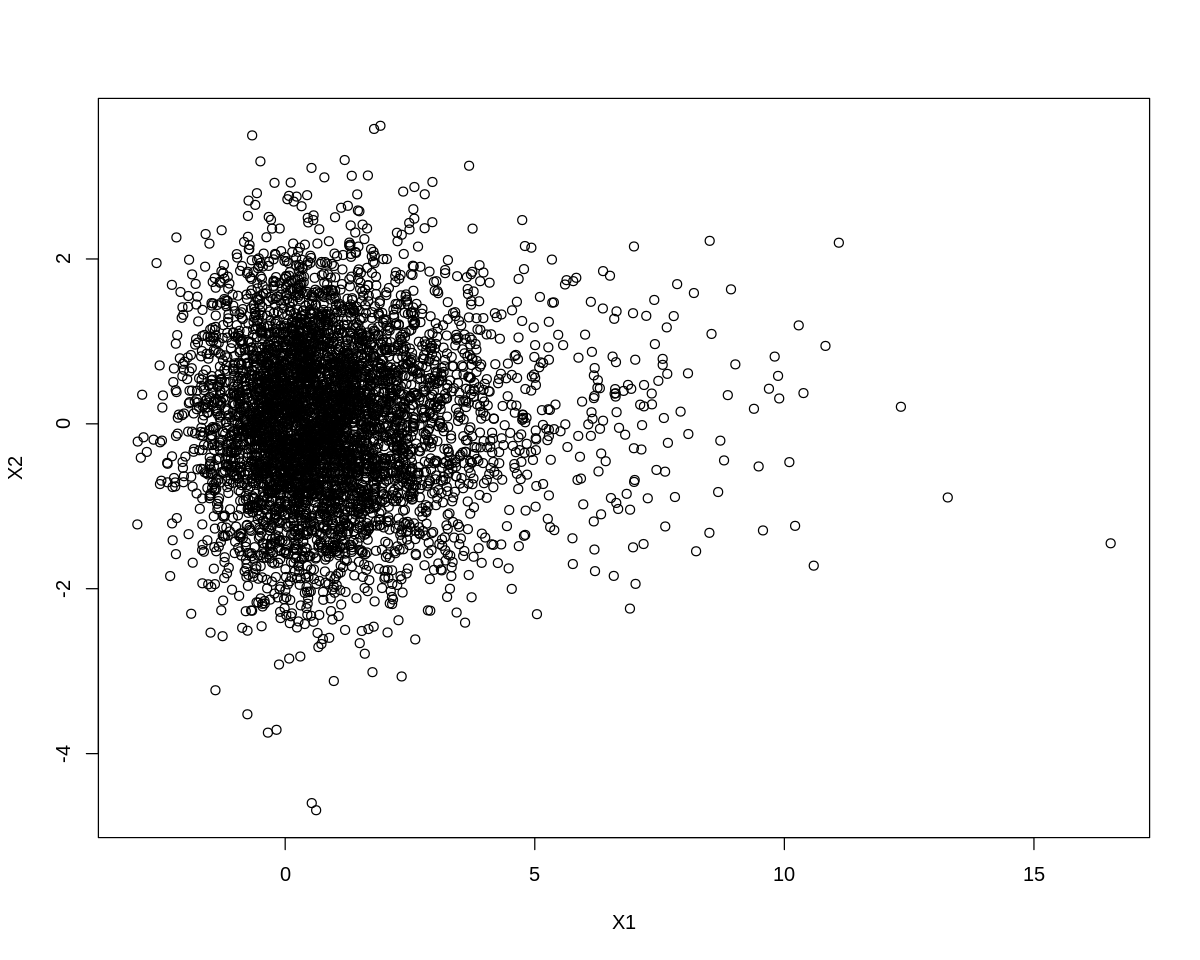

In [ ]:
plot(fatoracao1[,c('X1','X2')])

In [ ]:
write.csv(fatoracao1, file='df_fatoracao1.csv')

In [ ]:
dim(fatoracao1)

[1] 5000    2

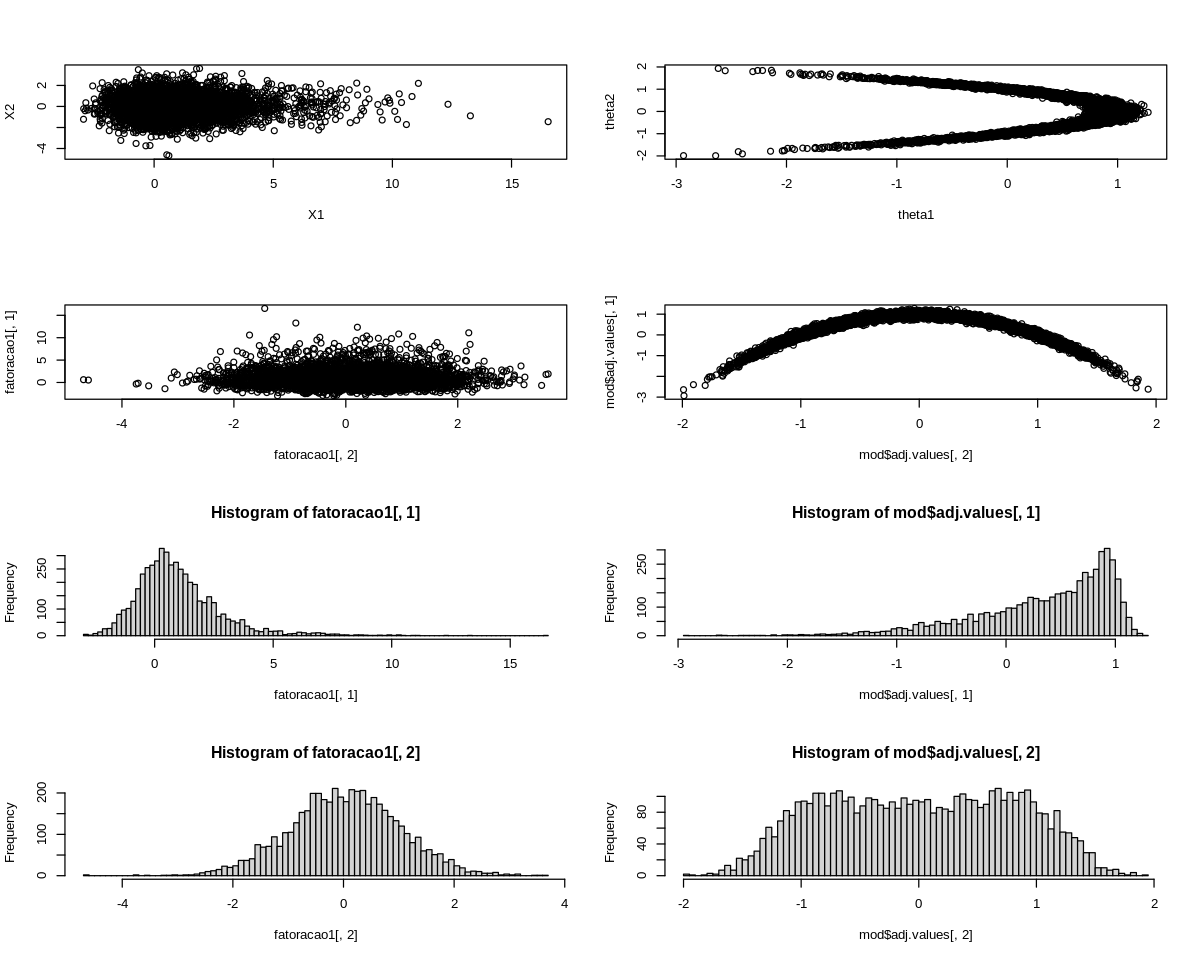

In [ ]:
par(mfrow=c(4,2))
plot(fatoracao1)
plot(mod$adj.values)
plot(fatoracao1[, 2], fatoracao1[, 1])
plot(mod$adj.values[, 2], mod$adj.values[, 1])
hist(fatoracao1[, 1], breaks=100)
hist(mod$adj.values[, 1], breaks=100)
hist(fatoracao1[, 2], breaks=100)
hist(mod$adj.values[, 2], breaks=100)

#### **4.2.3.2 Regressão quantílica + fatoração p(theta_2|y) * p(theta_1|theta_2,y)**

In [ ]:
#Dados para estimar Theta1

Xtrain <- base_train[,c(1,3)]#tirar o 4
Xtest <- base_test[,c(1,3)]#tirar o 4
Ytrain <- base_train[,2]
Ytest <- base_test[,2]

#.....................................................
#Dados para estimar Theta2

Xtrain2 <- base_train[,c(1)]
Xtest2 <- base_test[,c(1)]
Ytrain2 <- base_train[,3]
Ytest2 <- base_test[,3]

#===============================================================================

     loss       mae 
0.2475258 3.1228707 


Time difference of 1.360286 hours

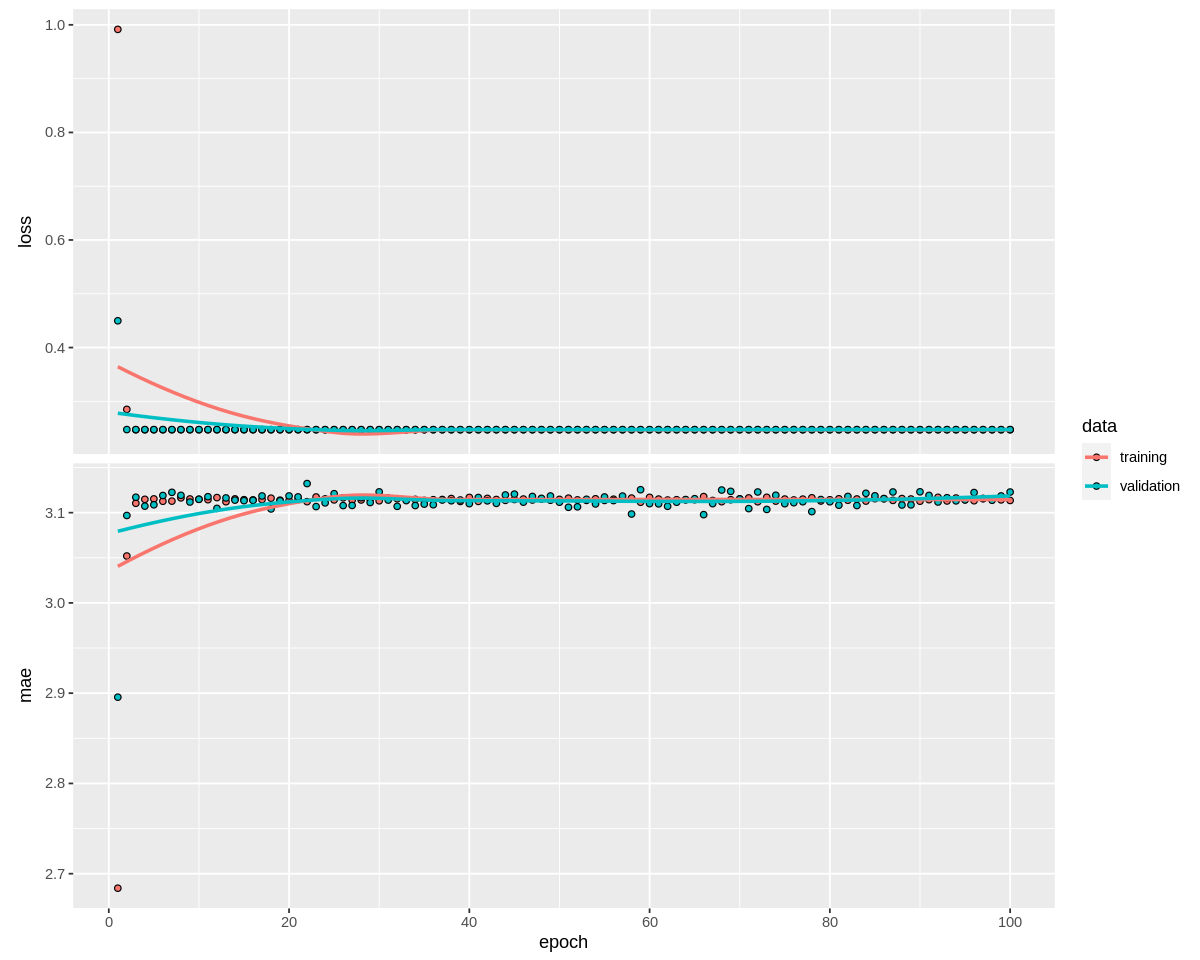

     loss       mae 
0.1478169 1.7359977 


Time difference of 1.369249 hours

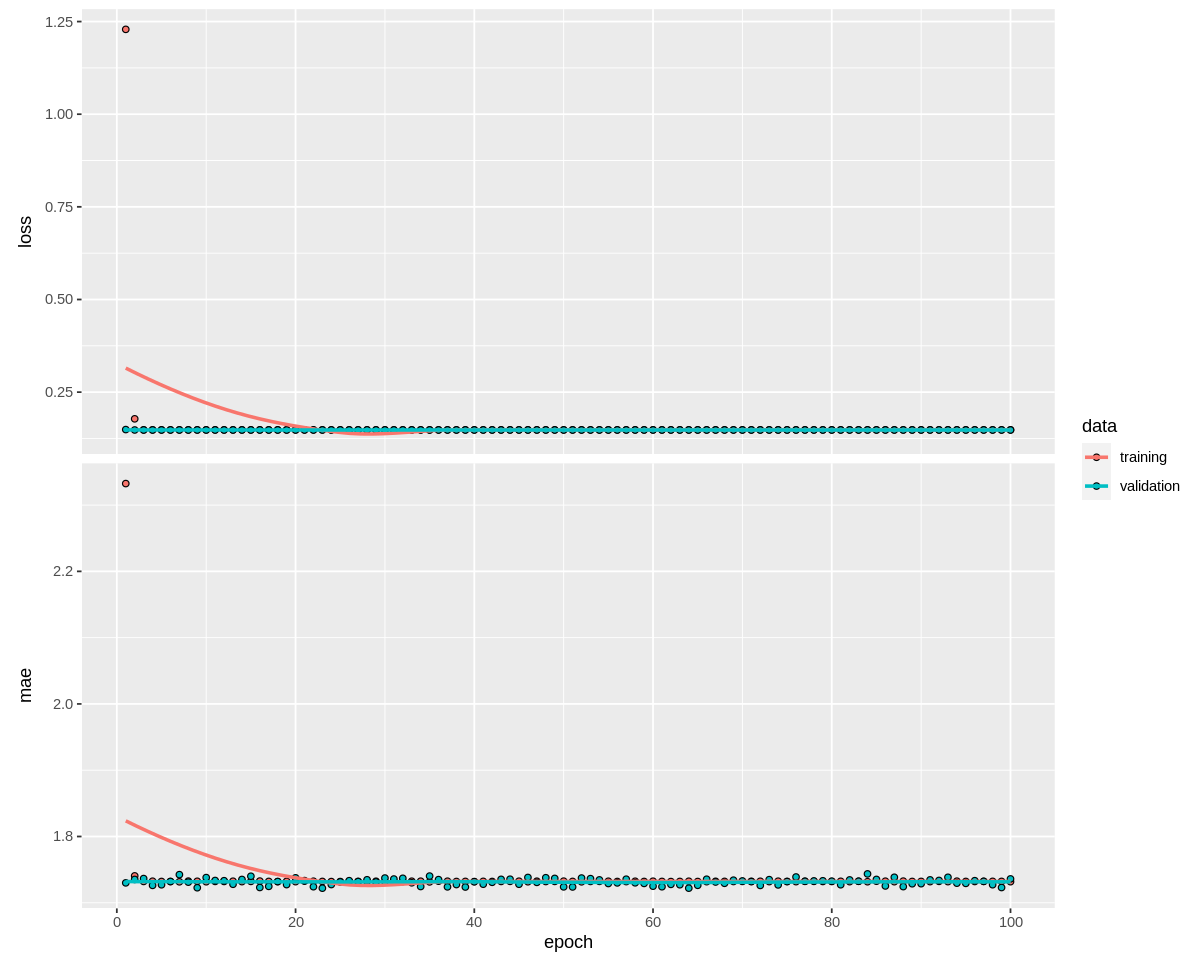

In [ ]:
# ajuste do modelo =============================================================
#Definição do Grid
gTau = seq(-6,6,0.1)#função logito
#Transformação Logito
tau = 1/(1+exp(-gTau))
#tau =c(.1,.1,.1,.1,.1)
inicio<-Sys.time()
fitTheta1 = fitRq(x = Xtrain,
                  y = Ytrain,
                  xtest=Xtest,
                  ytest=Ytest,
                  tau = tau)

fim<-Sys.time()
fim-inicio
inicio<-Sys.time()
fitTheta2 = fitRq(x = Xtrain2,
                  y = Ytrain2,
                  xtest=Xtest2,
                  ytest=Ytest2,
                  tau = tau)
fim<-Sys.time()
fim-inicio
#===============================================================================

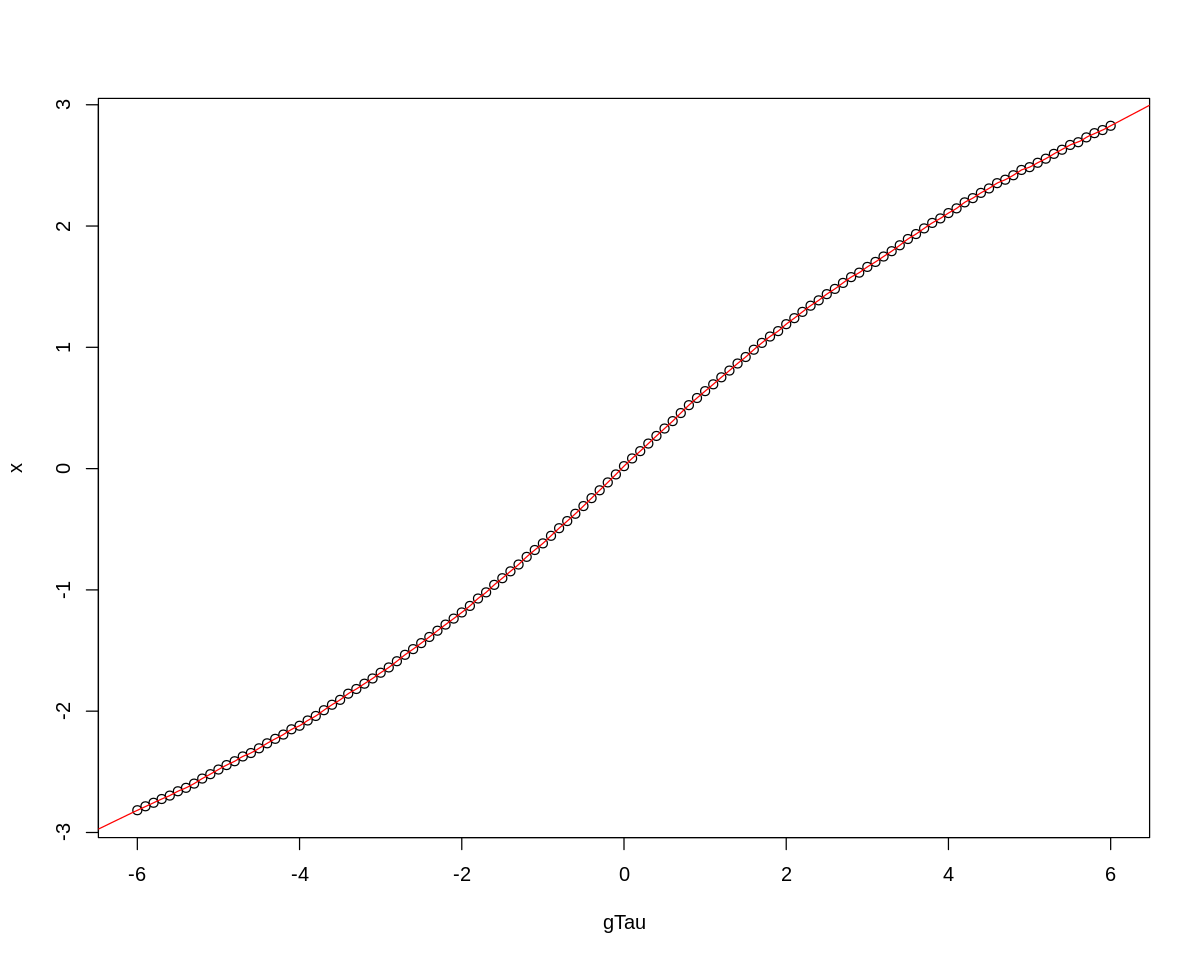

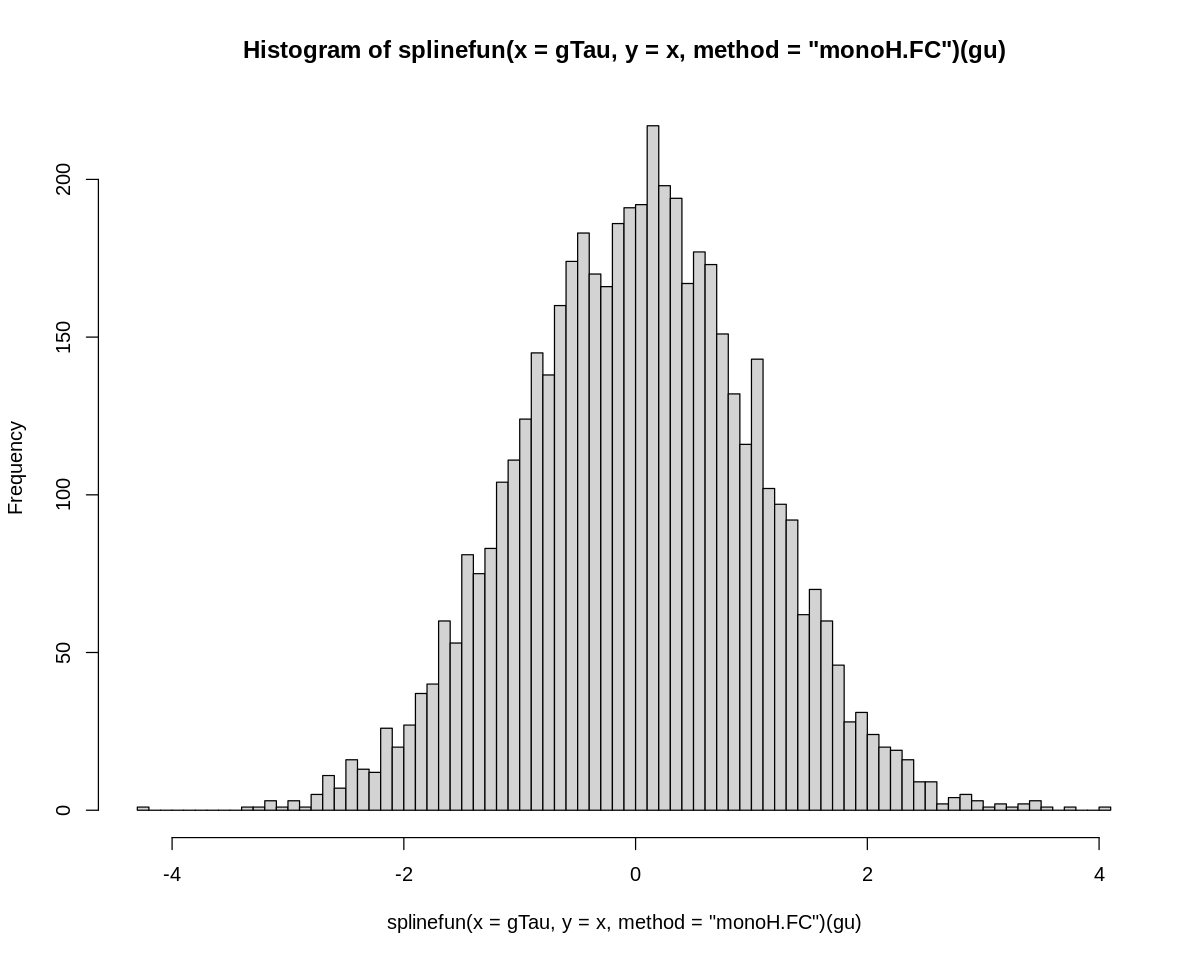

In [ ]:
thetaHat2 = predictRq(fitTheta2, matrix(c(1),ncol=1), tau)
x = as.numeric(thetaHat2)
u = runif(5000, .0, 1)
gu = log(u/(1-u))
gTau = seq(-6,6,0.1)
#TransformaÃ§Ã£o Logito
tau = 1/(1+exp(-gTau))

#par(mfrow = c(1,2))
plot(gTau,x)
lines(sort(gu),splinefun(x = gTau, y = x,method ="monoH.FC")(sort(gu)),col='red')
#plot(x,tau)
hist(splinefun(x = gTau, y =  x,method ="monoH.FC")(gu),breaks=100)

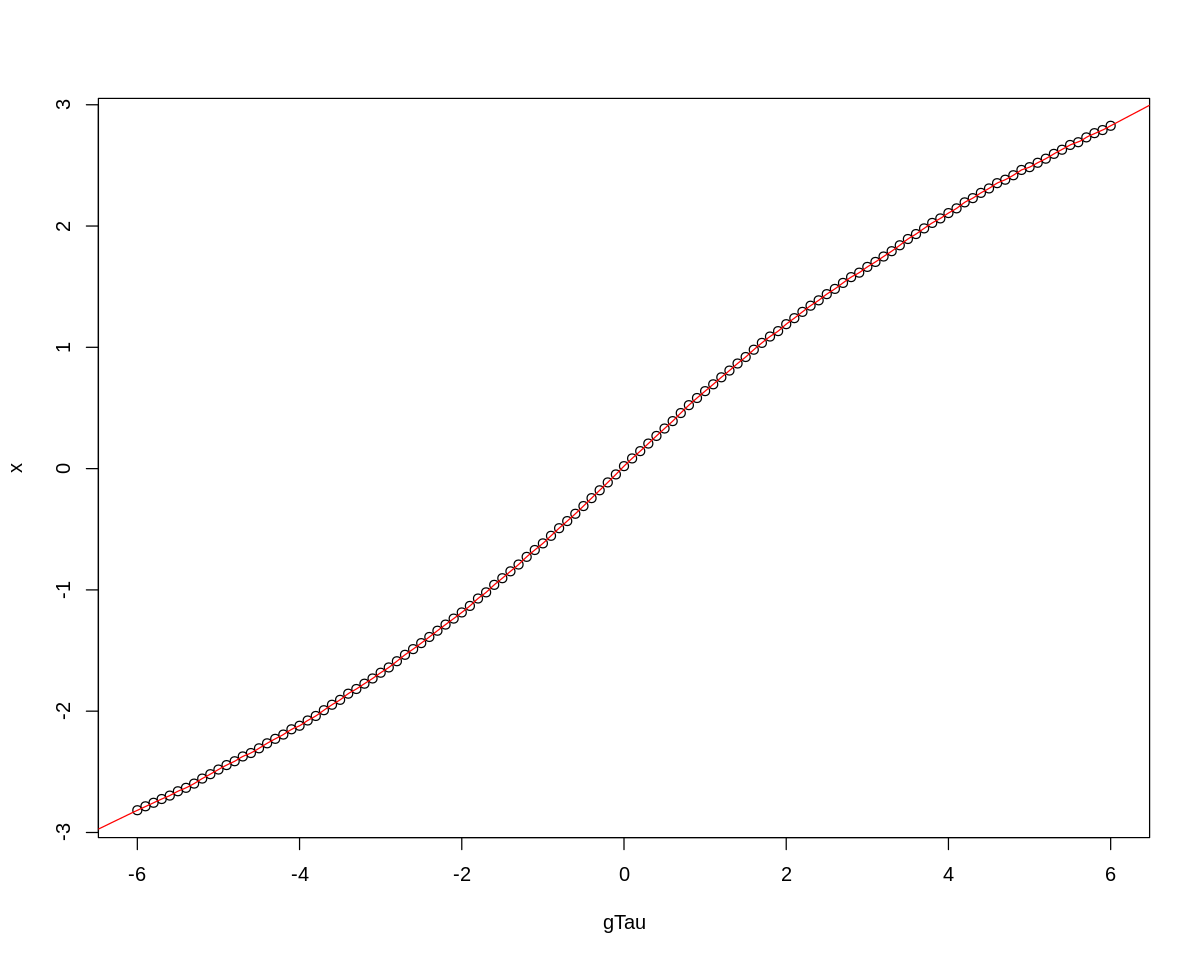

In [ ]:
plot(gTau,x)
lines(sort(gu),splinefun(x = gTau, y = sort(x),method ="monoH.FC")(sort(gu)),col='red')

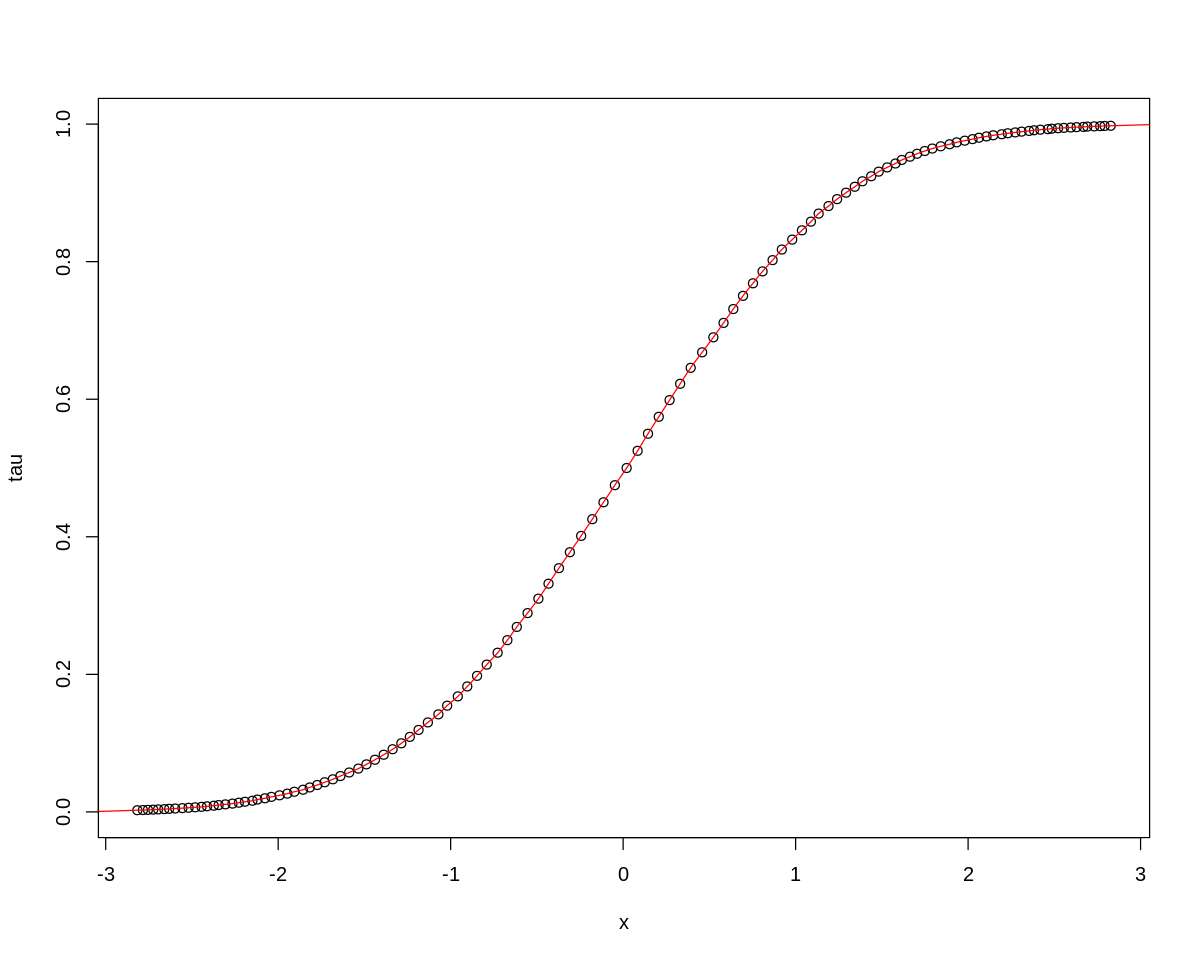

In [ ]:
plot(x,tau)
lines(sort(gu),splinefun(x = sort(x), y = tau,method ="monoH.FC")(sort(gu)),col='red')

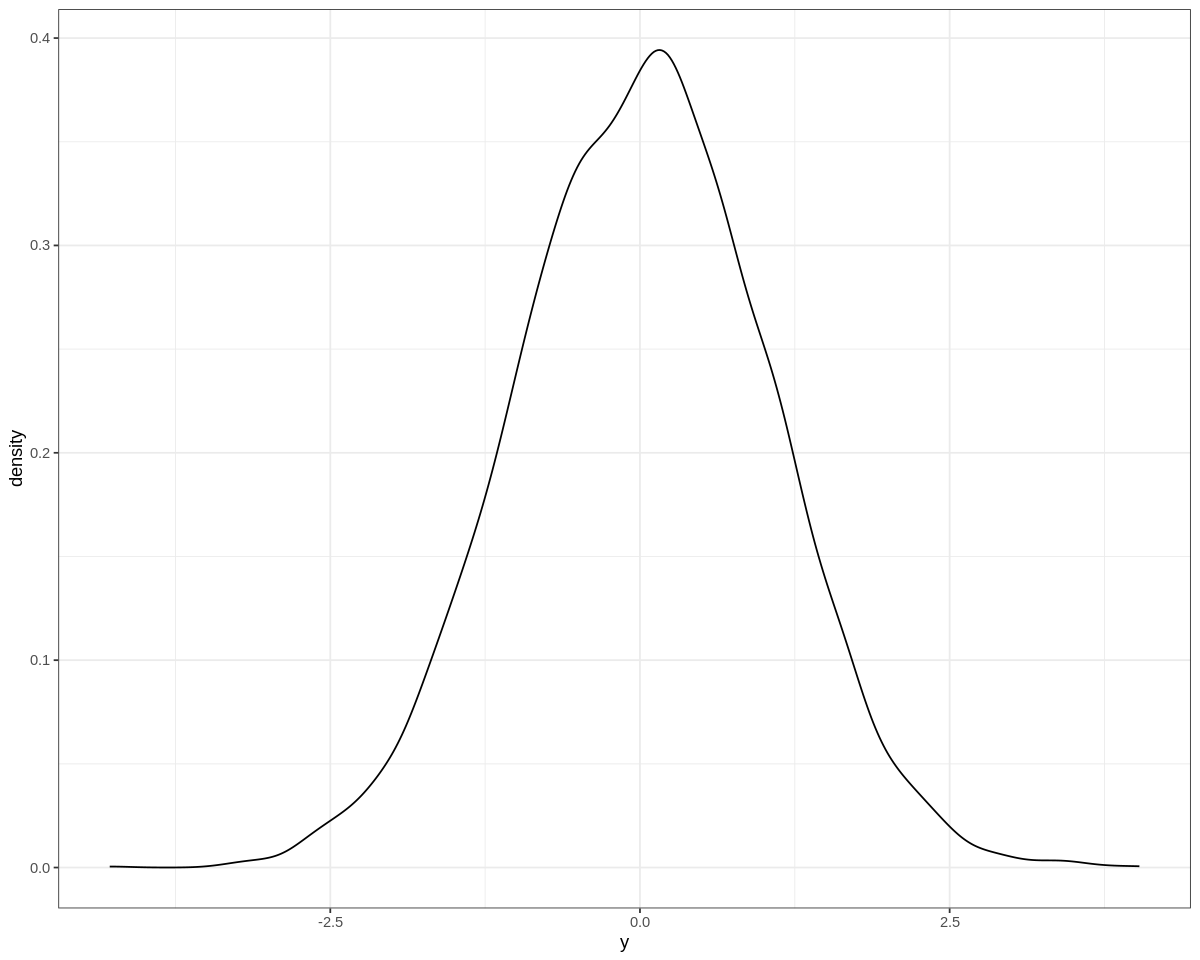

In [ ]:
df<-data.frame(x=gu,y=splinefun(x = gTau, y =  sort(x),method ="monoH.FC")(gu))
ggplot(df, aes(x=y)) + 
  geom_density()+
  theme_bw()

In [ ]:
# fatoração ========================================================================
outG =  data.frame(matrix(NA, m.gibbs, nc = 3))
names(outG) = c('y', 'theta1', 'theta2')
#valor inicial s0:
outG[,1] = rep(1, m.gibbs)
#valor inicial para theta:
outG[1,2:3] = c(0, 0)

inicio<-Sys.time()
#obtencao dos valores preditos pelo modelo:
thetaHat2 = predictRq(fitTheta2, matrix(c(1),ncol=1), tau)
x = as.numeric(thetaHat2)
u = runif(m.gibbs, .0, 1)
gu = log(u/(1-u))
outG$theta2 = splinefun(x = gTau, y = sort(x),method ="monoH.FC")(gu)

for(i in 1:m.gibbs){
  #theta2:
  #obtencao dos valores preditos pelo modelo:
  thetaHat1 = predictRq(fitTheta1, outG[i,c(1,3)], tau)
  x = as.numeric(thetaHat1)
  u = runif(1, .0, 1)
  gu = log(u/(1-u))
 outG$theta1[i] = splinefun(x = gTau, y = sort(x),method ="monoH.FC")(gu)

}
fim<-Sys.time()
fim-inicio
fatoracao2<-outG[,c(2,3)]
colnames(fatoracao2)<-c('X1','X2')

Time difference of 5.613797 mins

In [ ]:
write.csv(fatoracao2, file='df_fatoracao2.csv')

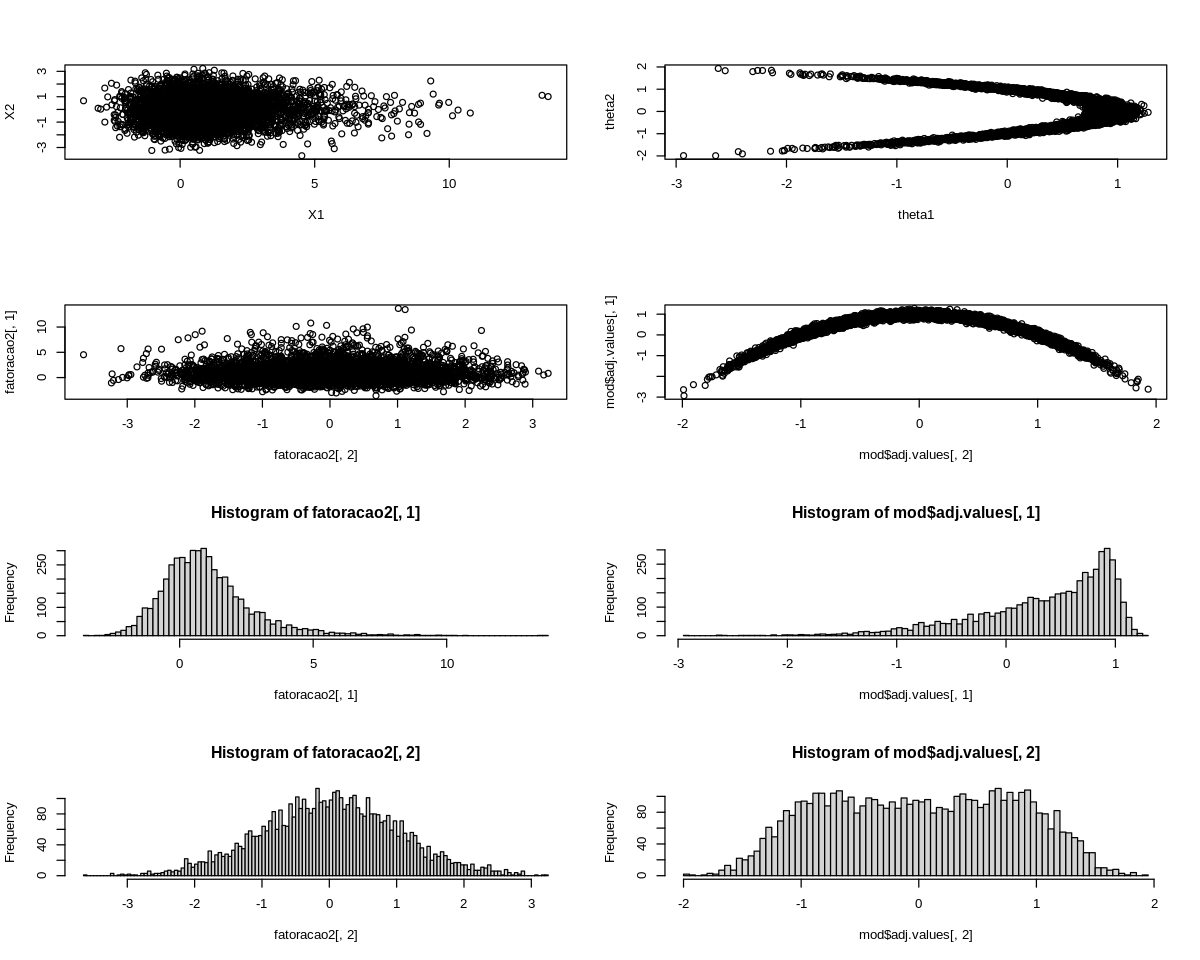

In [ ]:
par(mfrow=c(4,2))
plot(fatoracao2)
plot(mod$adj.values)
plot(fatoracao2[, 2], fatoracao2[, 1])
plot(mod$adj.values[, 2], mod$adj.values[, 1])
hist(fatoracao2[, 1], breaks=100)
hist(mod$adj.values[, 1], breaks=100)
hist(fatoracao2[, 2], breaks=100)
hist(mod$adj.values[, 2], breaks=100)

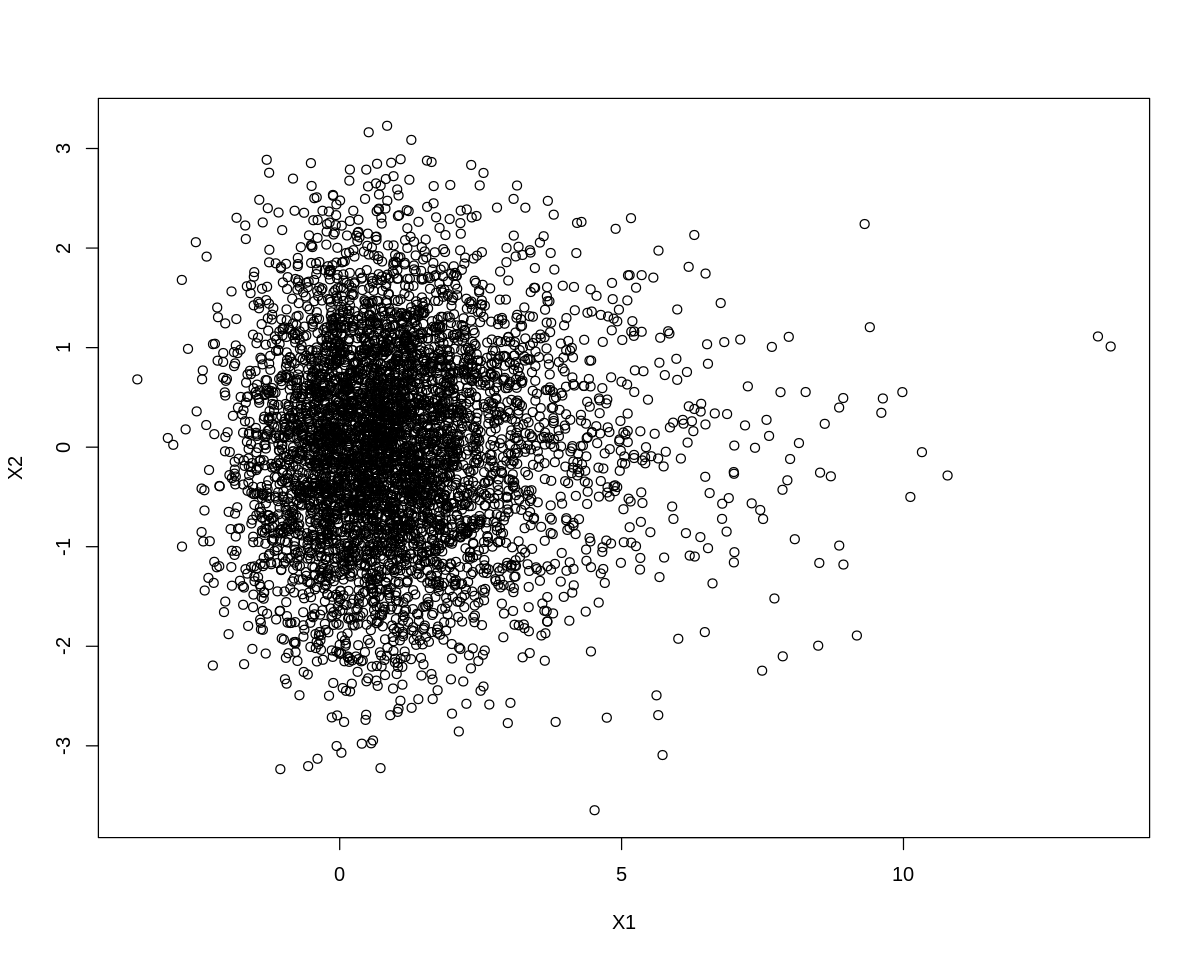

In [ ]:
plot(fatoracao2)

#### **4.2.3.4 Regressão quantílica + Gibbs p(theta_1|y) * p(theta_2|theta_1,y)**

In [ ]:
head(regM1)

,X,y,theta1,theta2
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.8324769,-0.05899895,1.0062561
2,2,-1.0289802,-1.09435228,-0.1037783
3,3,-0.7105748,-0.95041144,-0.5715805
4,4,-1.4172778,-1.51505041,0.3599283
5,5,-1.0437013,-1.33421868,0.6305324
6,6,-1.5758563,-1.76595965,-0.3383551


In [ ]:
## PCA ponderado
  
  w=mod$weights
  X=as.matrix(regM1[,3:4])
  
  #aplicando a tecnica:
  mu = c()
  for(i in 1:ncol(X)) mu[i] = 1/sum(w)*sum(w*X[,i])
  XCenter = X
  for(i in 1:ncol(X)) XCenter[,i] = X[,i] - mu[i]
  
  wX = matrix(NA, nc = ncol(X), nr = nrow(X))
  for(i in 1:ncol(X)) wX[,i] = w*X[,i]  
  XtWX = t(X)%*%wX
  XCov = 1/sum(w)*XtWX
  
  modPca = prcomp(XCov)
  
  #Aplicando transformação
  wpca= X%*%modPca$rotation
  
  # Agrupando Dados com thetas transformados
  
  regM3 <- regM1[,c('s1','s2')]
  regM3$theta1<-wpca[,1]
  regM3$theta2<-wpca[,2]
  regM3$pesos<-w

  

ERROR: ignored

In [ ]:

## PCA ponderado
  
  w=mod$weights
  X=as.matrix(regM1[,3:4])
  
  #aplicando a tecnica:
  mu = c()
  for(i in 1:ncol(X)) mu[i] = 1/sum(w)*sum(w*X[,i])
  XCenter = X
  for(i in 1:ncol(X)) XCenter[,i] = X[,i] - mu[i]
  
  wX = matrix(NA, nc = ncol(X), nr = nrow(X))
  for(i in 1:ncol(X)) wX[,i] = w*X[,i]  
  XtWX = t(X)%*%wX
  XCov = 1/sum(w)*XtWX
  
  modPca = prcomp(XCov)
  
  #Aplicando transformação
  wpca= X%*%modPca$rotation
  
  # Agrupando Dados com thetas transformados
  
  regM3 <- as.data.frame(cbind(regM1[,c('s1','s2')],wpca,w))
  names(regM3) <- c("s1", "s2", "theta1", "theta2","pesos")
  
## Redes neurais modelos lineares

# data split ===================================================================

n=nrow(regM3)
#Separacao base de treino e validacao
indextrain <- sample(1:n,round(0.8*n),replace=FALSE)
base_train <- regM3[ indextrain,]
base_test <- regM3[-indextrain,]
base_train <- regM3[ indextrain,]
base_test <- regM3[-indextrain,]

#Dados para estimar Theta1

Xtrain <- base_train[,c(1,3)]
Xtest <- base_test[,c(1,3)]
Ytrain <- base_train[,2]
Ytest <- base_test[,2]

#.....................................................
#Dados para estimar Theta2

Xtrain2 <- base_train[,c(1:2)]
Xtest2 <- base_test[,c(1:2)]
Ytrain2 <- base_train[,3]
Ytest2 <- base_test[,3]

# ajuste do modelo =============================================================
#Definição do Grid
gTau = seq(-6,6,0.1)#função logito
#Transformação Logito
tau = 1/(1+exp(-gTau))
#tau =c(.1,.1,.1,.1,.1)
fitTheta1 = fitRq(x = Xtrain,
                  y = Ytrain,
                  xtest=Xtest,
                  ytest=Ytest,
                  tau = tau)

fitTheta2 = fitRq(x = Xtrain2,
                  y = Ytrain2,
                  xtest=Xtest2,
                  ytest=Ytest2,
                  tau = tau)

ERROR: ignored

In [ ]:
## Gibbs
outG =  data.frame(matrix(NA, m.gibbs, nc = 4))
names(outG) = c('s1', 's2', 'theta1', 'theta2')
#valor inicial s0:
outG[,1:2] = rep(s0, m.gibbs)
#valor inicial para theta:
outG[1,3:4] = c(0, 0)

#aplicacao da funcao logito ao tau:
gTau = log(tau/(1-tau))
for(i in 2:5000){
  
  #theta1:  
  #obtencao dos valores preditos pelo modelo:
  thetaHat1 = predictRq(fitTheta1, outG[i-1,-3], tau)
  x = as.numeric(thetaHat1)
  
  #pegando o valor de x correspondente:
  
  outG[i,3]=NA
  while (is.na(outG[i,3]) )
  {
    #sorteio do numero aleatorio e aplicacao da funcao logito:
    u = runif(1, .0, 1)
    gu = log(u/(1-u))
    
    #cat('replica:', i, '| u:', u, '| gu:', gu, '| aprox:',
    #    as.numeric(splinefun(x = gTau, y = x,method ="monoH.FC")(gu)), '\n')
    outG[i,3] = splinefun(x = gTau, y = x,method ="monoH.FC")(gu)
  }
  
  
  #theta2:
  
  #obtencao dos valores preditos pelo modelo:
  thetaHat2 = predictRq(fitTheta2, outG[i,-4], tau)
  x = as.numeric(thetaHat2)
  
  #pegando o valor de x correspondente:
  
  outG[i,4]=NA
  while (is.na(outG[i,4]) )
  {
    #sorteio do numero aleatorio e aplicacao da funcao logito:
    u = runif(1, .0, 1)
    gu = log(u/(1-u))
    
    #cat('replica:', i, '| u:', u, '| gu:', gu, '| aprox:',
    #    as.numeric(splinefun(x = gTau, y = x,method ="monoH.FC")(gu)), '\n')
    outG[i,4] = splinefun(x = gTau, y = x,method ="monoH.FC")(gu)
  }
}
  
  #reverter os valores transformados
  
transformada=data.matrix(outG[,c(3,4)])
theta_algoritmo4=t(t(transformada %*% t(modPca$rotation)))
names(theta_algoritmo4) <- c("theta1", "theta2")

      loss        mae 
0.01717304 0.21654999 


Time difference of 1.224227 hours

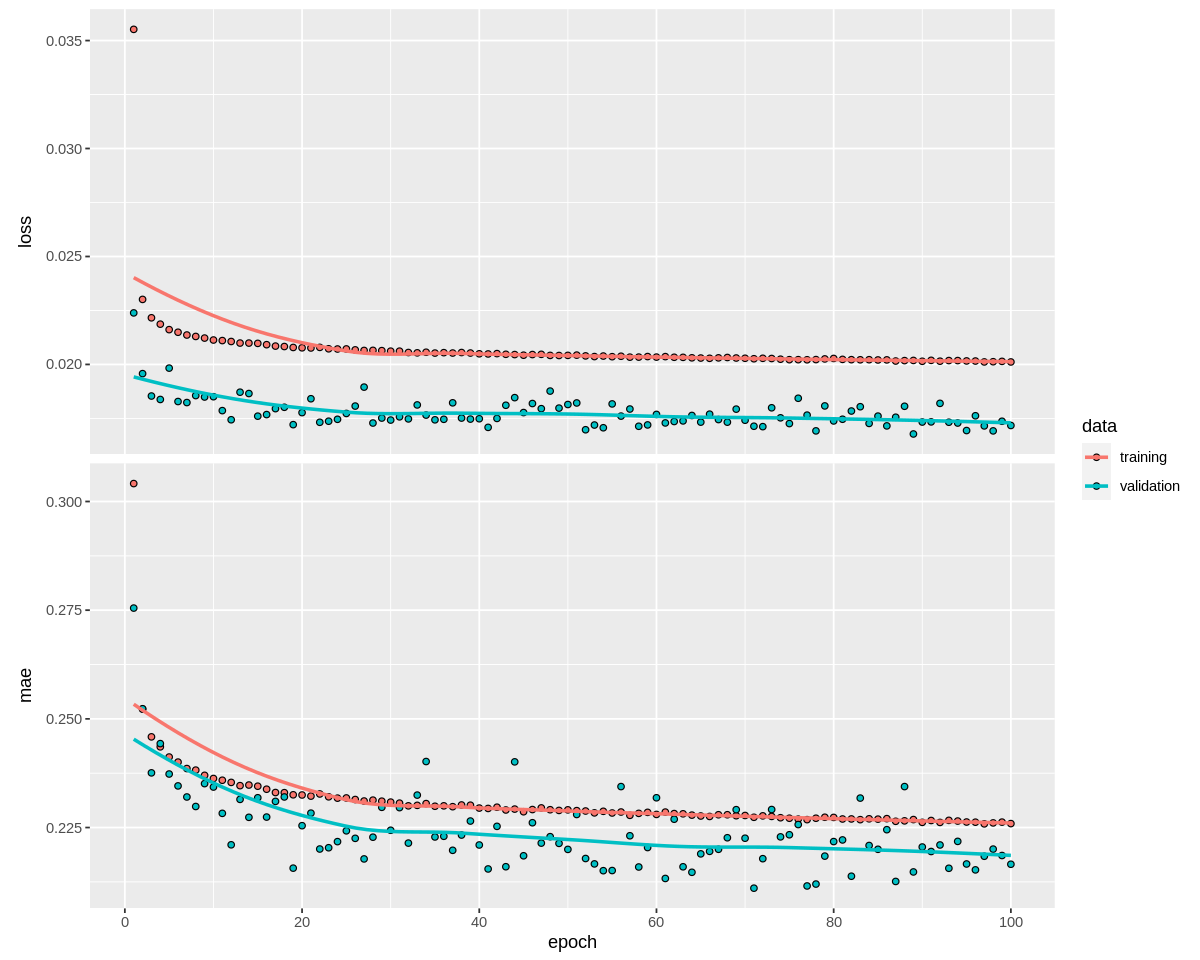

      loss        mae 
0.09885153 0.91290414 


Time difference of 1.242447 hours

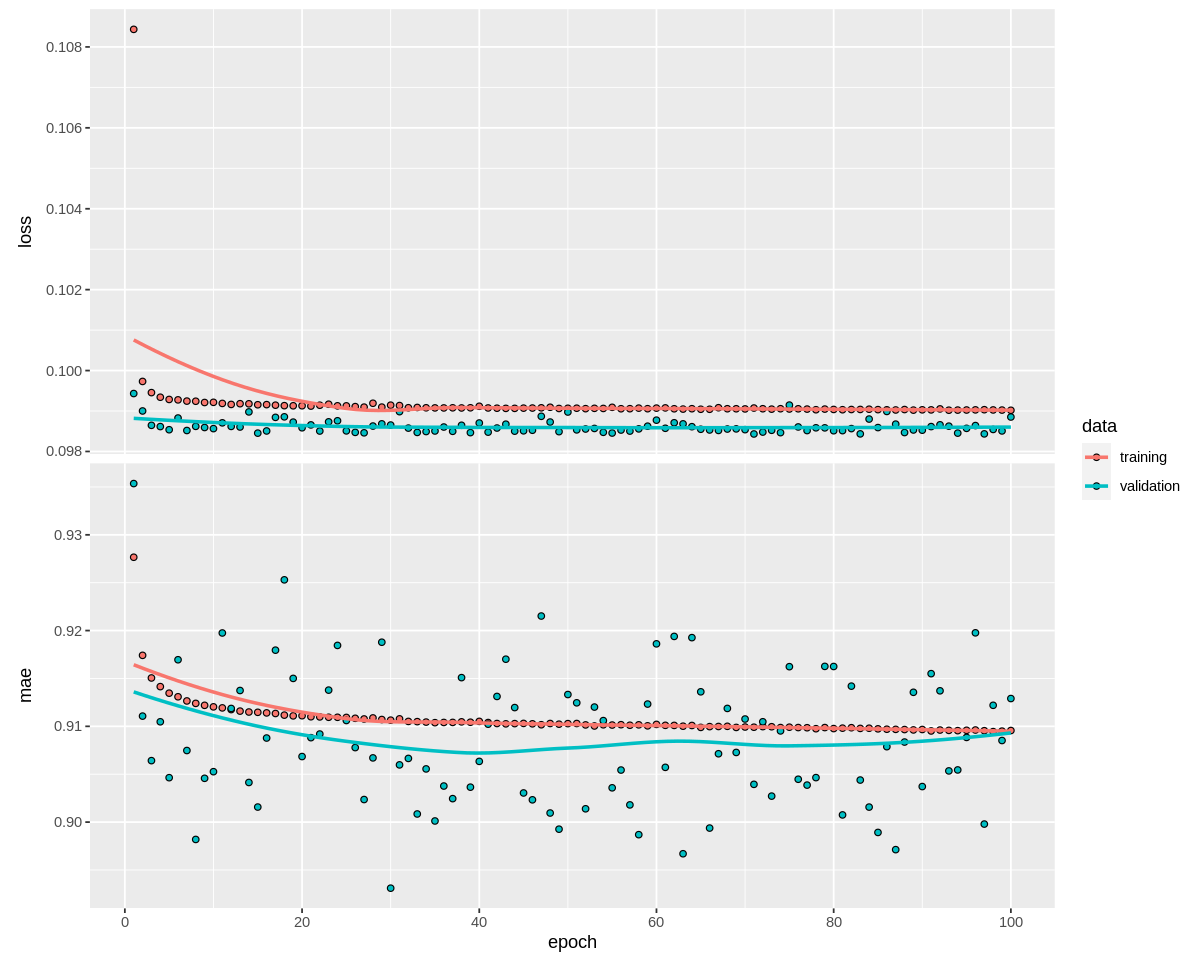

In [ ]:
#Dados para estimar Theta1

Xtrain <- base_train[,c(1,3)]
Xtest <- base_test[,c(1,3)]
Ytrain <- base_train[,2]
Ytest <- base_test[,2]

#.....................................................
#Dados para estimar Theta2

Xtrain2 <- base_train[,c(1:2)]
Xtest2 <- base_test[,c(1:2)]
Ytrain2 <- base_train[,3]
Ytest2 <- base_test[,3]

# ajuste do modelo =============================================================
#Definição do Grid
gTau = seq(-6,6,0.1)#função logito
#Transformação Logito
tau = 1/(1+exp(-gTau))
#tau =c(.1,.1,.1,.1,.1)

inicio<-Sys.time()
fitTheta1 = fitRq(x = Xtrain,
                  y = Ytrain,
                  xtest=Xtest,
                  ytest=Ytest,
                  tau = tau)
fim<-Sys.time()
fim-inicio
inicio<-Sys.time()
fitTheta2 = fitRq(x = Xtrain2,
                  y = Ytrain2,
                  xtest=Xtest2,
                  ytest=Ytest2,
                  tau = tau)
fim<-Sys.time()
fim-inicio
#===============================================================================

In [ ]:
## Gibbs
outG =  data.frame(matrix(NA, m.gibbs, nc = 3))
names(outG) = c('y', 'theta1', 'theta2')
#valor inicial s0:
outG[,1] = rep(1, m.gibbs)
#valor inicial para theta:
outG[1,2:3] = c(0, 0)

inicio<-Sys.time()
#aplicacao da funcao logito ao tau:
gTau = log(tau/(1-tau))
for(i in 2:5000){
  
  #theta1:  
  #obtencao dos valores preditos pelo modelo:
  thetaHat1 = predictRq(fitTheta1, outG[i-1,-2], tau)
  x = as.numeric(thetaHat1)
  
  #pegando o valor de x correspondente:
  
  outG[i,3]=NA
  while (is.na(outG[i,2]) )
  {
    #sorteio do numero aleatorio e aplicacao da funcao logito:
    u = runif(1, .0, 1)
    gu = log(u/(1-u))
    outG[i,2] = splinefun(x = gTau, y = sort(x),method ="monoH.FC")(gu)
  }
  
  
  #theta2:
  
  #obtencao dos valores preditos pelo modelo:
  thetaHat2 = predictRq(fitTheta2, outG[i,-3], tau)
  x = as.numeric(thetaHat2)
  
  #pegando o valor de x correspondente:
  
  outG[i,3]=NA
  while (is.na(outG[i,3]) )
  {
    #sorteio do numero aleatorio e aplicacao da funcao logito:
    u = runif(1, .0, 1)
    gu = log(u/(1-u))

    outG[i,3] = splinefun(x = gTau, y = sort(x),method ="monoH.FC")(gu)
  }
}
fim<-Sys.time()
fim-inicio
gibbs=outG

Time difference of 7.804817 mins

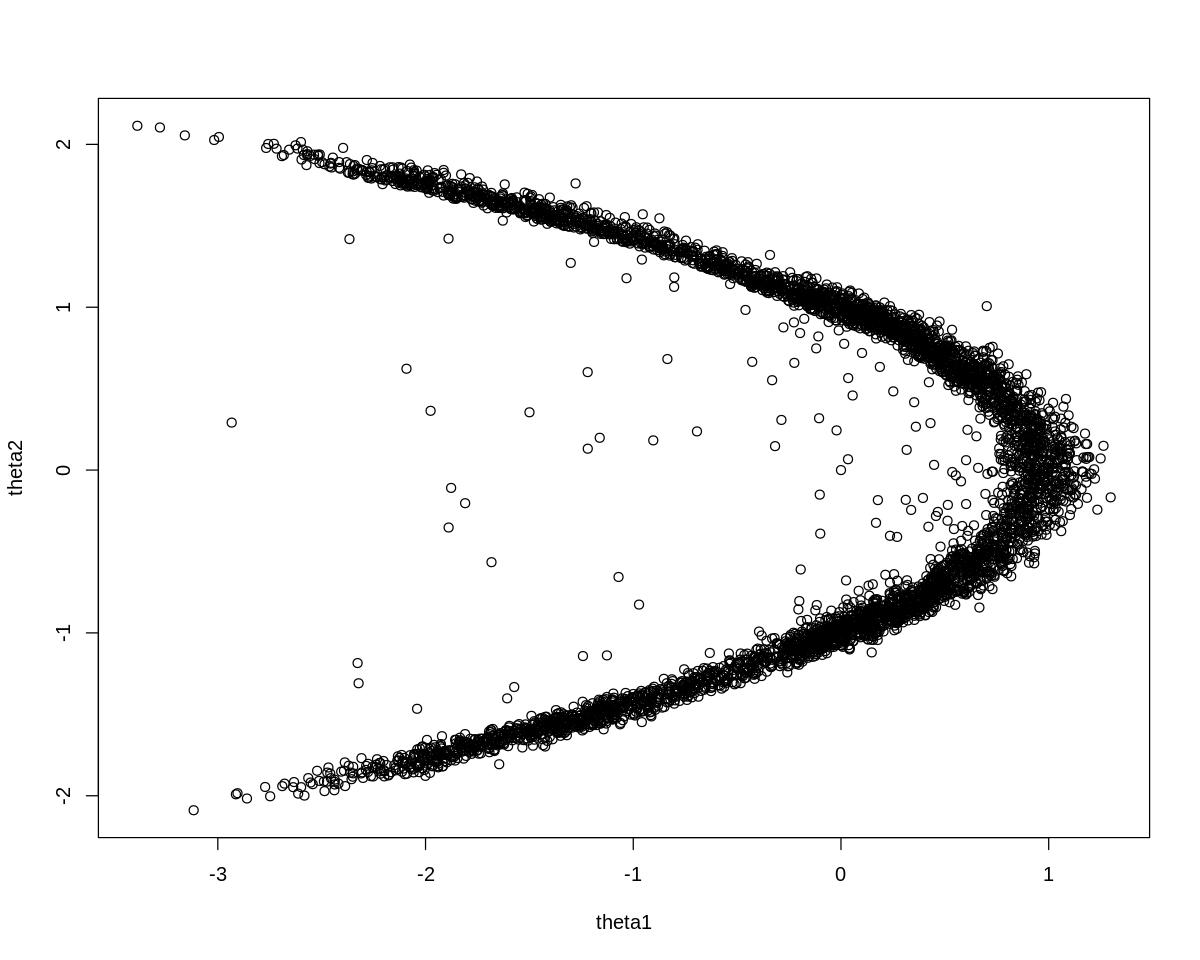

In [ ]:
plot(gibbs[,c(2,3)])

In [ ]:
write.csv(gibbs, file='df_gibbs.csv')

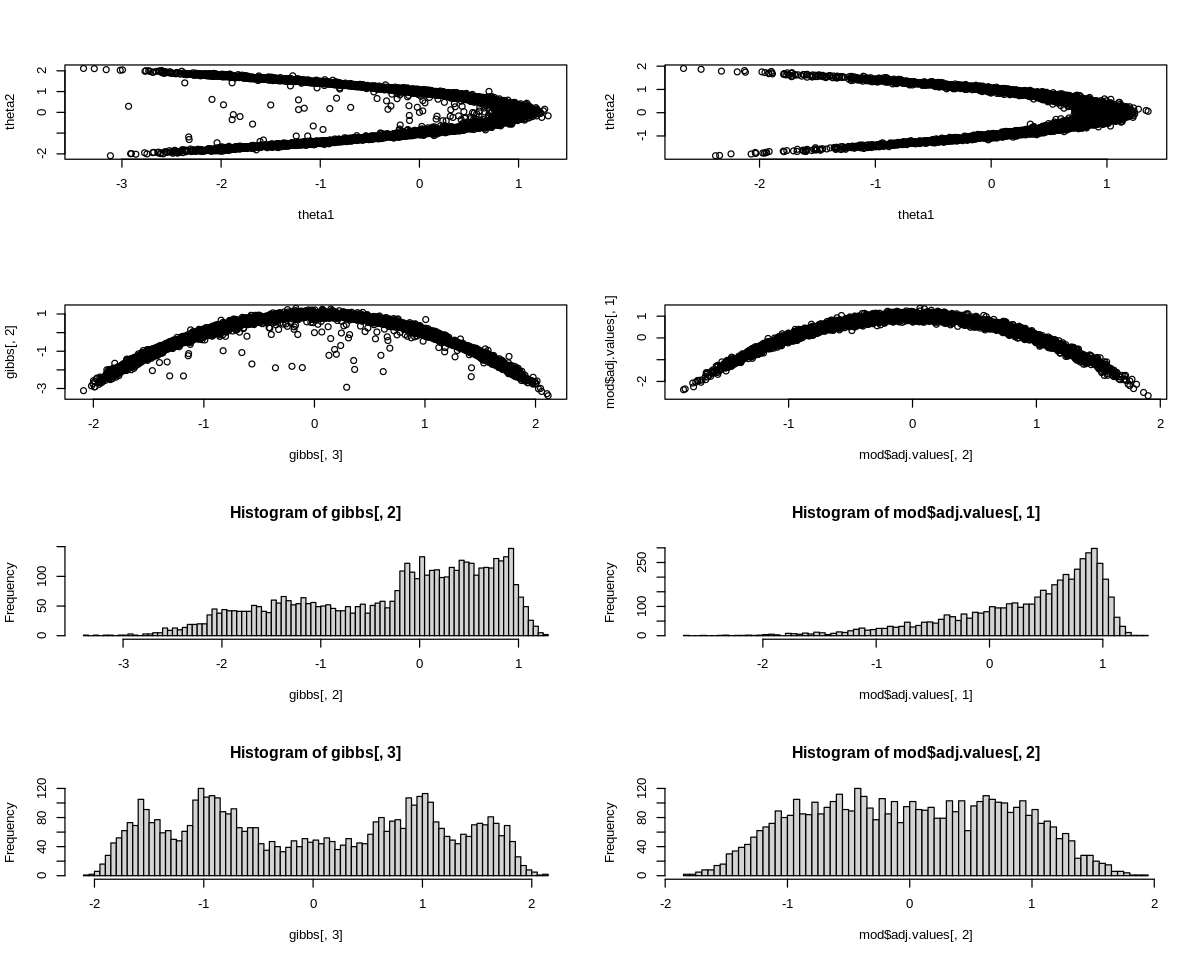

In [ ]:
par(mfrow=c(4,2))
plot(gibbs[,c(2,3)])
plot(mod$adj.values)
plot(gibbs[, 3], gibbs[, 2])
plot(mod$adj.values[, 2], mod$adj.values[, 1])
hist(gibbs[, 2], breaks=100)
hist(mod$adj.values[, 1], breaks=100)
hist(gibbs[, 3], breaks=100)
hist(mod$adj.values[, 2], breaks=100)

### **4.2.4 Gráficos de comparação**

#### **4.2.4.1. Medidas descritivas da posteriori**

In [ ]:
fatoracao1<-read.csv('df_fatoracao1.csv')
fatoracao2<-read.csv('df_fatoracao2.csv')
gibbs<-read.csv('df_gibbs.csv')
mod<-read.csv2('mod_adjvalues.csv')

Warning message in file(file, "rt"):
“cannot open file 'mod_adjvalues.csv': No such file or directory”


ERROR: ignored

In [ ]:
data.frame(algoritmo=c('fatoração p(theta_1|y) * p(theta_2|theta_1,y)','fatoração p(theta_1|y) * p(theta_2|theta_1,y)',
'fatoração p(theta_2|y) * p(theta_1|theta_2,y)','fatoração p(theta_2|y) * p(theta_1|theta_2,y)',
#'fatoração normal','fatoração normal',
'Gibbs','Gibbs'),
variavel=c('theta_1','theta_2','theta_1','theta_2',
#'theta_1','theta_2',
'theta_1','theta_2'),media=c(
mean(fatoracao1[,1]),
mean(fatoracao1[,2]),
mean(fatoracao2[,1]),
mean(fatoracao2[,2]),
#mean(fatoracao3[,1]),
#mean(fatoracao3[,2]),
mean(gibbs[,1]),
mean(gibbs[,2])),
desvio_padrao=c(sd(fatoracao1[,1]),
sd(fatoracao1[,2]),
sd(fatoracao2[,1]),
sd(fatoracao2[,2]),
#sd(fatoracao3[,1]),
#sd(fatoracao3[,2]),
sd(gibbs[,1]),
sd(gibbs[,2])
))

#### **4.2.4.2. Distribuições a posteriori**

In [ ]:
ggplot(data.frame(mod),aes(x=theta1, y=theta2))+
  geom_point(alpha =.5)+geom_density_2d(size=1,col='red',cex=.01)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))#+
#  xlim(-2.5, 2.5)+ylim(-2, 2)

Warning message:
“Duplicated aesthetics after name standardisation: size”
Warning message:
“Removed 3 rows containing non-finite values (`stat_density2d()`).”


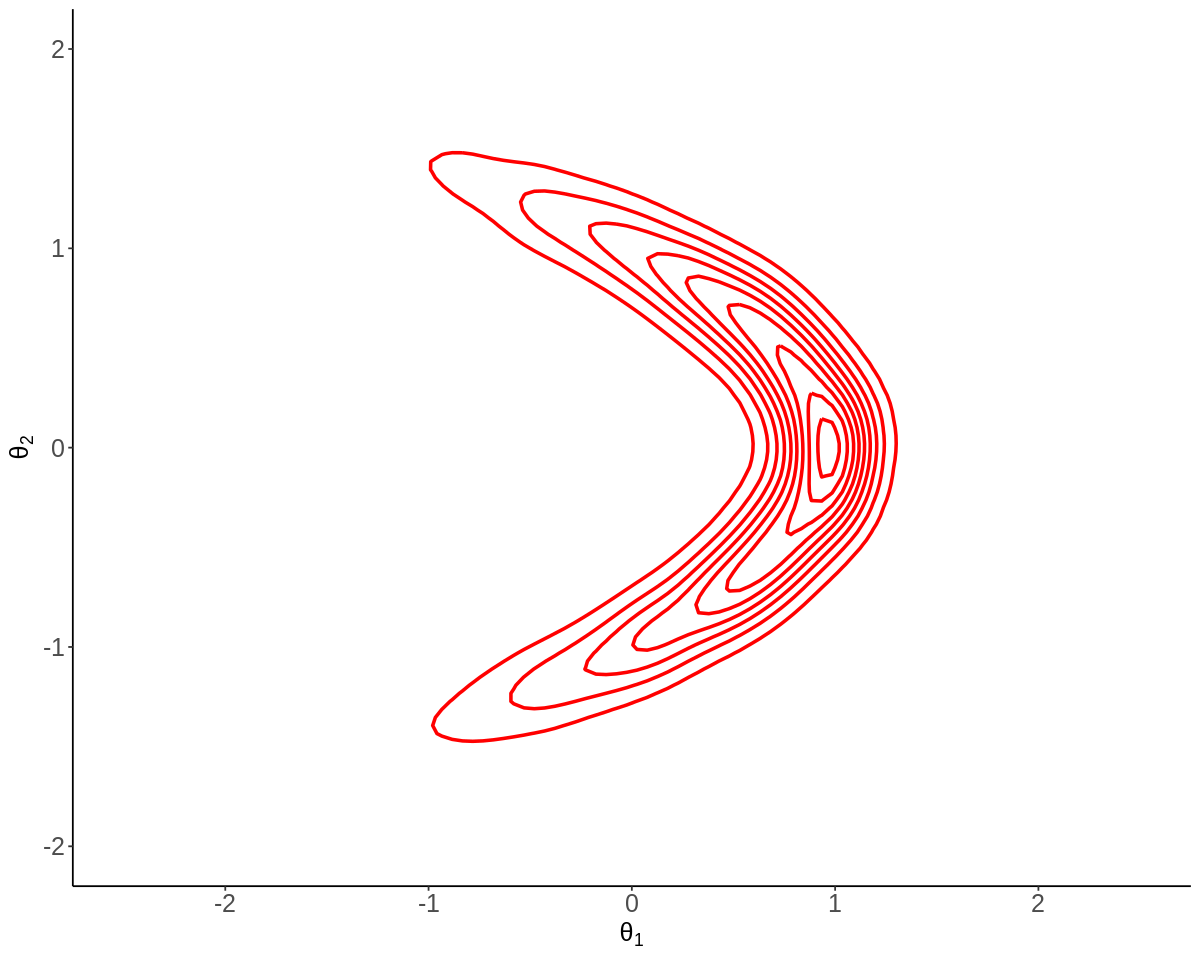

In [ ]:
ggplot(fatoracao1,aes(x=X1, y=X2))+
  #geom_point(alpha =.5)+
  geom_density_2d(size=1,col='red',cex=.01)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(fatoracao2,aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1,col='red',cex=.01)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(fatoracao3,aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1,col='red',cex=.01)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(gibbs,aes(x=theta1, y=theta2))+
  geom_point()+geom_density_2d(size=1,col='red',cex=.01)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
fatoracao1$categoria<-'fatoracao1'
fatoracao2$categoria<-'fatoracao2'
#fatoracao3$categoria<-'fatoracao3'
gibbs$categoria<-'gibbs'
colnames(gibbs)[c(3,4)]<-c('X1','X2')
juntos<-rbind(rbind(fatoracao1[,c(2:4)],fatoracao2[,c(2:4)]),gibbs[,c(3:5)])
ggplot(juntos,aes(x=X1, y=X2,colour=factor(categoria)))+
  geom_point()+
  theme_bw()+
  geom_density_2d(aes(group = categoria),col='white')+ labs(colour = "Algoritmos",x=expression(theta[1]),y=expression(theta[2]))

#### **4.2.4.3. Densidades das distribuições a posteriori**

In [ ]:
abc<-data.frame(mod[,c(2,3)])
abc$categoria<-'abc'
colnames(abc)[c(1,2)]<-c('X1','X2')
juntos<-rbind(juntos,abc)

In [ ]:
ggplot(juntos, aes(X1, colour = categoria)) +
  geom_density()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y='Densidade',colour='Algoritmo')+
  xlim(-2.1,2.1)

In [ ]:
ggplot(juntos, aes(X2, colour = categoria)) +
  geom_density()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[2]),y='Densidade',colour='Algoritmo')+
  xlim(-2.1,2.1)

#### **4.2.4.4. Gráfico ACF**

In [ ]:
par(mfrow=c(4,2))
acf(juntos[juntos$categoria=='fatoracao1',1],main=paste0('ACF de ',expression(theta[1]),' - Fatoração 1'))
acf(juntos[juntos$categoria=='fatoracao1',2],main=paste0('ACF de ',expression(theta[2]),' - Fatoração 1'))
acf(juntos[juntos$categoria=='fatoracao2',1],main=paste0('ACF de ',expression(theta[1]),' - Fatoração 2'))
acf(juntos[juntos$categoria=='fatoracao2',2],main=paste0('ACF de ',expression(theta[2]),' - Fatoração 2'))
acf(juntos[juntos$categoria=='fatoracao3',1],main=paste0('ACF de ',expression(theta[1]),' - Algoritmo 1'))
acf(juntos[juntos$categoria=='fatoracao3',2],main=paste0('ACF de ',expression(theta[2]),' - Algoritmo 1'))
acf(juntos[juntos$categoria=='gibbs',1],main=paste0('ACF de ',expression(theta[1]),' - Gibbs'))
acf(juntos[juntos$categoria=='gibbs',2],main=paste0('ACF de ',expression(theta[2]),' - Gibbs'))

In [ ]:
acf(juntos[juntos$categoria=='abc',1],main=paste0('ACF de ',expression(theta[1]),'ABC'))

In [ ]:
acf(juntos[juntos$categoria=='abc',1],main=paste0('ACF de ',expression(theta[2]),' ABC'))

In [ ]:
acf(juntos[juntos$categoria=='fatoracao1',1],main=paste0('ACF de ',expression(theta[1]),' - Fatoração 1'))

In [ ]:
acf(juntos[juntos$categoria=='fatoracao1',2],main=paste0('ACF de ',expression(theta[2]),' - Fatoração 1'))

In [ ]:
acf(juntos[juntos$categoria=='fatoracao2',1],main=paste0('ACF de ',expression(theta[1]),' - Fatoração 2'))

In [ ]:
acf(juntos[juntos$categoria=='fatoracao2',2],main=paste0('ACF de ',expression(theta[2]),' - Fatoração 2'))

In [ ]:
acf(juntos[juntos$categoria=='fatoracao3',1],main=paste0('ACF de ',expression(theta[1]),' - Algoritmo 1'))

In [ ]:
acf(juntos[juntos$categoria=='fatoracao3',2],main=paste0('ACF de ',expression(theta[2]),' - Algoritmo 1'))

In [ ]:
acf(juntos[juntos$categoria=='gibbs',1],main=paste0('ACF de ',expression(theta[1]),' - Gibbs'))

In [ ]:
acf(juntos[juntos$categoria=='gibbs',2],main=paste0('ACF de ',expression(theta[2]),' - Gibbs'))

#### **4.2.4.5. Erro médio acumulado pelo tamanho da cadeia**

In [ ]:
fim<-NULL
m.gibbs<-5000
for(j in 2:m.gibbs){
theta1.abc=mean(juntos[juntos$categoria=='abc',1][c(1:j)])
theta2.abc=mean(juntos[juntos$categoria=='abc',2][c(1:j)])
theta1.algoritmo1=mean(juntos[juntos$categoria=='fatoracao1',1][c(1:j)])
theta2.algoritmo1=mean(juntos[juntos$categoria=='fatoracao1',2][c(1:j)])
theta1.algoritmo2=mean(juntos[juntos$categoria=='fatoracao2',1][c(1:j)])
theta2.algoritmo2=mean(juntos[juntos$categoria=='fatoracao2',1][c(1:j)])
#theta1.algoritmo3=mean(juntos[juntos$categoria=='fatoracao3',1])
#theta2.algoritmo3=mean(juntos[juntos$categoria=='fatoracao3',1])
theta1.algoritmo4=mean(juntos[juntos$categoria=='gibbs',1][c(1:j)])
theta2.algoritmo4=mean(juntos[juntos$categoria=='gibbs',1][c(1:j)])

final<-data.frame(tamanho=j,algoritmo=c('abc','Fatoração 1','Fatoração 2',#'Fatoração 3',
'Gibbs'),
theta1=c(theta1.abc,theta1.algoritmo1,theta1.algoritmo2,#theta1.algoritmo3,
theta1.algoritmo4),
theta2=c(theta2.abc,theta2.algoritmo1,theta2.algoritmo2,#theta2.algoritmo3,
theta2.algoritmo4))
fim<-rbind(fim,final)
}


fim$distancia_euclidiana<-sqrt(((fim$theta1-1)^2)+((fim$theta2-1)^2))

In [ ]:
ggplot(data=fim, aes(x=tamanho, y=distancia_euclidiana, colour=algoritmo)) +
   geom_line()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1),
    legend.title = element_text(size = 15),
    legend.text = element_text(size = 12)
    )+
  labs(y='MSE médio',x='Tamanho da amostra',colour='Algoritmo')

In [ ]:
ggplot(data=fim[fim$tamanho<2000,], aes(x=tamanho, y=distancia_euclidiana, colour=algoritmo)) +
   geom_line()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1),
    legend.title = element_text(size = 15),
    legend.text = element_text(size = 12)
    )+
  labs(y='MSE médio',x='Tamanho da amostra',colour='Algoritmo')

#### **4.2.4.6. Convergência da cadeia**

##### **4.2.4.6.1 Primeiras 50 observações**

In [ ]:
b<-data.frame(juntos[juntos$categoria=='fatoracao1',])[c(1:50),]
b$lagx2<-c(b$X2[2:50],NA)
b$lagx1<-c(b$X1[2:50],NA)

c<-data.frame(juntos[juntos$categoria=='fatoracao2',])[c(1:50),]
c$lagx2<-c(c$X2[2:50],NA)
c$lagx1<-c(c$X1[2:50],NA)

d<-data.frame(juntos[juntos$categoria=='fatoracao3',])[c(1:50),]
d$lagx2<-c(d$X2[2:50],NA)
d$lagx1<-c(d$X1[2:50],NA)

e<-data.frame(juntos[juntos$categoria=='gibbs',])[c(1:50),]
e$lagx2<-c(e$X2[2:50],NA)
e$lagx1<-c(e$X1[2:50],NA)

f<-data.frame(juntos[juntos$categoria=='abc',])[c(1:50),]
f$lagx2<-c(f$X2[2:50],NA)
f$lagx1<-c(f$X1[2:50],NA)

In [ ]:
ggplot(f,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='abc',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(b,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='fatoracao1',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(c,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='fatoracao2',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(d,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='fatoracao3',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

In [ ]:
ggplot(e,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='gibbs',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 2.5)+ylim(-2, 2)

##### **4.2.4.6.2 Últimas 50 observações**

In [ ]:
b<-data.frame(juntos[juntos$categoria=='fatoracao1',])[c(4950:4999),]
b$lagx2<-c(b$X2[2:50],NA)
b$lagx1<-c(b$X1[2:50],NA)

c<-data.frame(juntos[juntos$categoria=='fatoracao2',])[c(4950:4999),]
c$lagx2<-c(c$X2[2:50],NA)
c$lagx1<-c(c$X1[2:50],NA)

d<-data.frame(juntos[juntos$categoria=='fatoracao3',])[c(4950:4999),]
d$lagx2<-c(d$X2[2:50],NA)
d$lagx1<-c(d$X1[2:50],NA)

e<-data.frame(juntos[juntos$categoria=='gibbs',])[c(4950:4999),]
e$lagx2<-c(e$X2[2:50],NA)
e$lagx1<-c(e$X1[2:50],NA)

In [ ]:
ggplot(b,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='fatoracao1',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))#+
  #xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   #scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   #scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(c,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='fatoracao2',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))#+
  #xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   #scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   #scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(d,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='fatoracao3',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))#+
  #xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   #scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   #scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(e,aes(x=X1, y=X2))+
geom_point(data=juntos[juntos$categoria=='gibbs',], aes(x=X1, y=X2), color='green')+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))#+
  #xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   #scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   #scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))